In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/segmento1_csv/cooperativas_segmento1_completo_final.csv")

print("Shape:", df.shape)
df.head(10)


Shape: (42, 46)


,INSTITUCIÓN,SEGMENTO,CALIFICADORA,CALIFICACIÓN,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,...,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES,FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,SEGMENTO 1,PACIFIC CREDIT RATING S.A.,AAA,1,-233.715,0.025,0.975,1.282,0.030,...,0.0,0.166,0.190,0.161,0.374,0.000,0.311,0.202,1.025,0.197
1,29 DE OCTUBRE LTDA,SEGMENTO 1,RIESGOS / CLASS INTERNATIONAL RATING,AA,2,2.184,0.073,0.927,1.040,0.055,...,0.0,0.146,0.137,0.151,0.278,0.157,0.857,0.084,1.073,0.079
2,ANDALUCIA LIMITADA,SEGMENTO 1,SUMMA RATINGS S.A. UNION RATINGS S.A. / PACIFIC,AA,2,0.600,0.193,0.807,0.913,0.000,...,0.0,0.154,0.170,0.147,0.359,0.000,0.450,0.094,1.193,0.079
3,ALIANZA DEL VALLE LIMITADA,SEGMENTO 1,RIESGOS / SUMMA RATINGS S.A.,AA,2,1.648,0.095,0.905,1.046,0.000,...,0.0,0.130,0.133,0.155,0.349,0.000,0.482,0.101,1.095,0.092
4,DE LOS\r\nSERVIDORES PUBLICOS DEL MINISTERIO D...,SEGMENTO 1,UNION RATINGS S.A.,AA,2,11.282,0.042,0.958,1.317,0.000,...,0.0,0.116,0.112,0.118,0.345,0.000,0.043,0.244,1.042,0.234
5,RIOBAMBA LTDA,SEGMENTO 1,RIESGOS S.A. MICRORIESG,AA,2,12.343,0.045,0.955,1.180,0.016,...,0.0,0.156,0.191,0.140,0.434,0.000,0.161,0.161,1.045,0.154
6,PEQUEÑA EMPRESA DE PASTAZA LIMITADA,SEGMENTO 1,CLASS INTERNATIONAL RATING,AA,2,7.345,0.069,0.931,1.165,0.000,...,0.0,0.189,0.238,0.160,0.344,0.000,0.206,0.163,1.069,0.152
7,ATUNTAQUI LIMITADA,SEGMENTO 1,CREDIT RATING S.A. MICROFINANZA CALIFICADORA DE,AA,2,2.400,0.061,0.939,1.037,0.016,...,0.0,0.152,0.150,0.136,0.365,0.000,0.625,0.069,1.061,0.065
8,JARDIN AZUAYO LIMITADA,SEGMENTO 1,WATCH RATINGS S.A.,AA,2,-22.964,0.039,0.961,1.101,0.087,...,0.0,0.159,0.304,0.148,0.492,0.000,0.364,0.103,1.039,0.099
9,JUVENTUD ECUATORIANA PROGRESISTA\r\nLIMITADA,SEGMENTO 1,RATINGS S.A.,AA,2,2.254,0.094,0.906,1.039,0.002,...,0.0,0.179,0.171,0.144,0.323,0.000,0.423,0.098,1.094,0.089


In [2]:
# Hacemos una copia del DataFrame original para trabajar sobre ella sin alterar 'df'
df_num = df.copy()

# Convertir TODO lo convertible a número:
# - Recorremos cada columna e intentamos convertir sus valores a tipos numéricos (int/float).
# - pd.to_numeric intenta la conversión; errors='ignore' deja la columna tal cual si no puede convertirla
#   (útil cuando hay columnas textuales que no representan números).
for col in df_num.columns:
    df_num[col] = pd.to_numeric(df_num[col], errors="ignore")

# Seleccionar solamente las columnas numéricas reales:
# - select_dtypes(include=[np.number]) devuelve columnas cuyo dtype es numérico (int/float).
# - columns.tolist() convierte el Index a una lista de nombres de columna.
num_cols = df_num.select_dtypes(include=[np.number]).columns.tolist()

# Mostrar cuántas columnas numéricas se detectaron y listar las primeras 20 (por claridad).
print("Columnas numéricas detectadas:", len(num_cols))
print(num_cols[:20])  # muestra solo las primeras 20


Columnas numéricas detectadas: 42
['RANKING', '( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS', 'ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS', 'ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO', 'MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO', 'MOROSIDAD DE LA CARTERA DE CONSUMO', 'MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO', 'MOROSIDAD DE LA CARTERA DE MICROCREDITO', 'MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO', 'MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO', 'MOROSIDAD DE LA CARTERA TOTAL', 'COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO', 'COBERTURA DE LA CARTERA DE CREDITO CONSUMO', 'COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO', 'COBERTURA DE LA CARTERA DE MICROCREDITO', 'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO', 'COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO', 'COBERTURA DE LA CARTERA PROBLEMÁTICA', 'GASTOS DE OPERACION ESTIMADOS / TOTAL ACTIVO PROMEDIO ']


C:\Users\marie\AppData\Local\Temp\ipykernel_12276\2535477468.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_num[col] = pd.to_numeric(df_num[col], errors="ignore")


# EDA




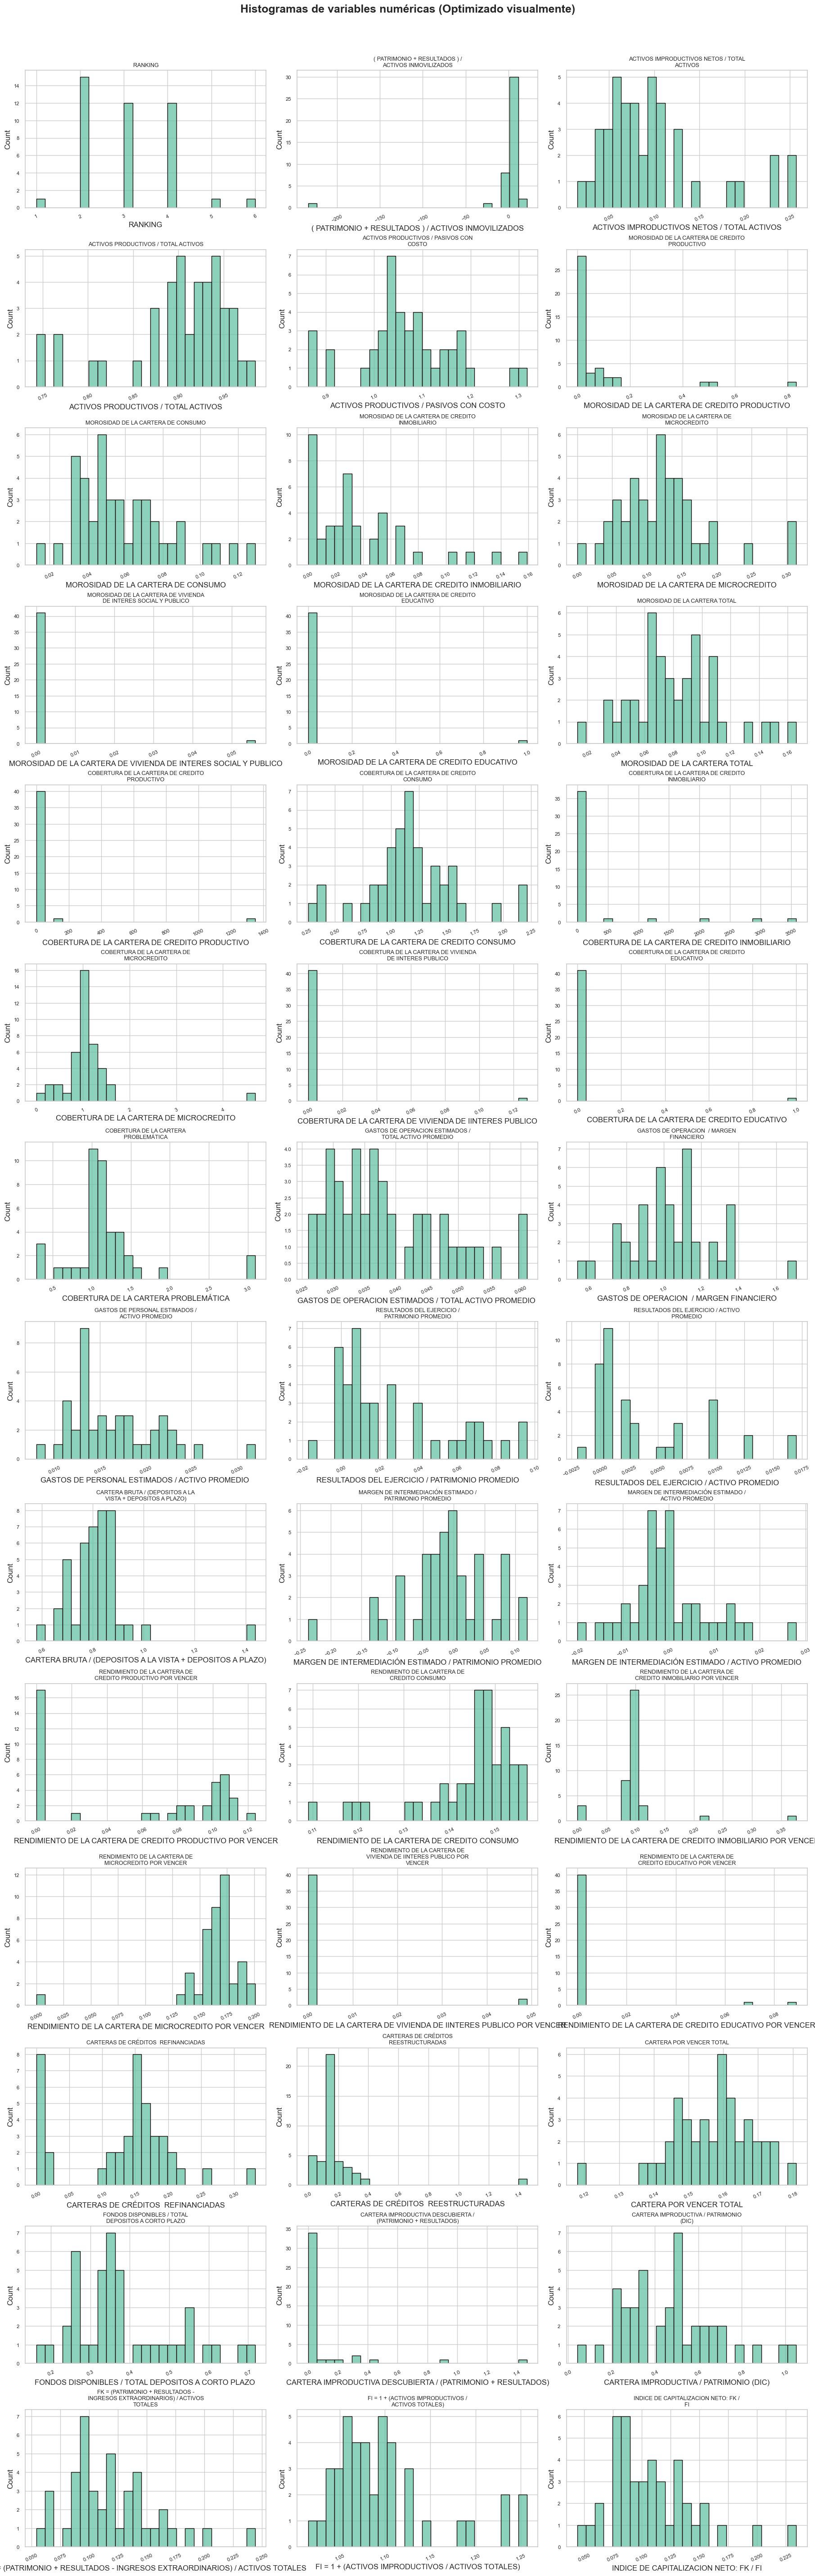

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import math

# Estilo general
sns.set(style="whitegrid", palette="Set2")

# DataFrame numérico ya limpio
df_plot = df_num[num_cols].copy()

# Configuración de grid
ncols = 3                                       # menos columnas → gráficos más grandes
nrows = math.ceil(len(df_plot.columns) / ncols)

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(18, 4 * nrows),
    constrained_layout=True
)
axes = axes.flatten()

for i, col in enumerate(df_plot.columns):
    sns.histplot(
        df_plot[col].dropna(),
        bins=25,
        ax=axes[i],
        edgecolor="black"
    )

    # Título multilínea bonito
    wrapped = "\n".join(textwrap.wrap(col, width=35))
    axes[i].set_title(wrapped, fontsize=9)

    axes[i].tick_params(axis="x", rotation=25, labelsize=8)
    axes[i].tick_params(axis="y", labelsize=8)

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    "Histogramas de variables numéricas (Optimizado visualmente)",
    fontsize=18,
    weight="bold",
    y=1.02
)
plt.show()


### Heatmap y correlaciones

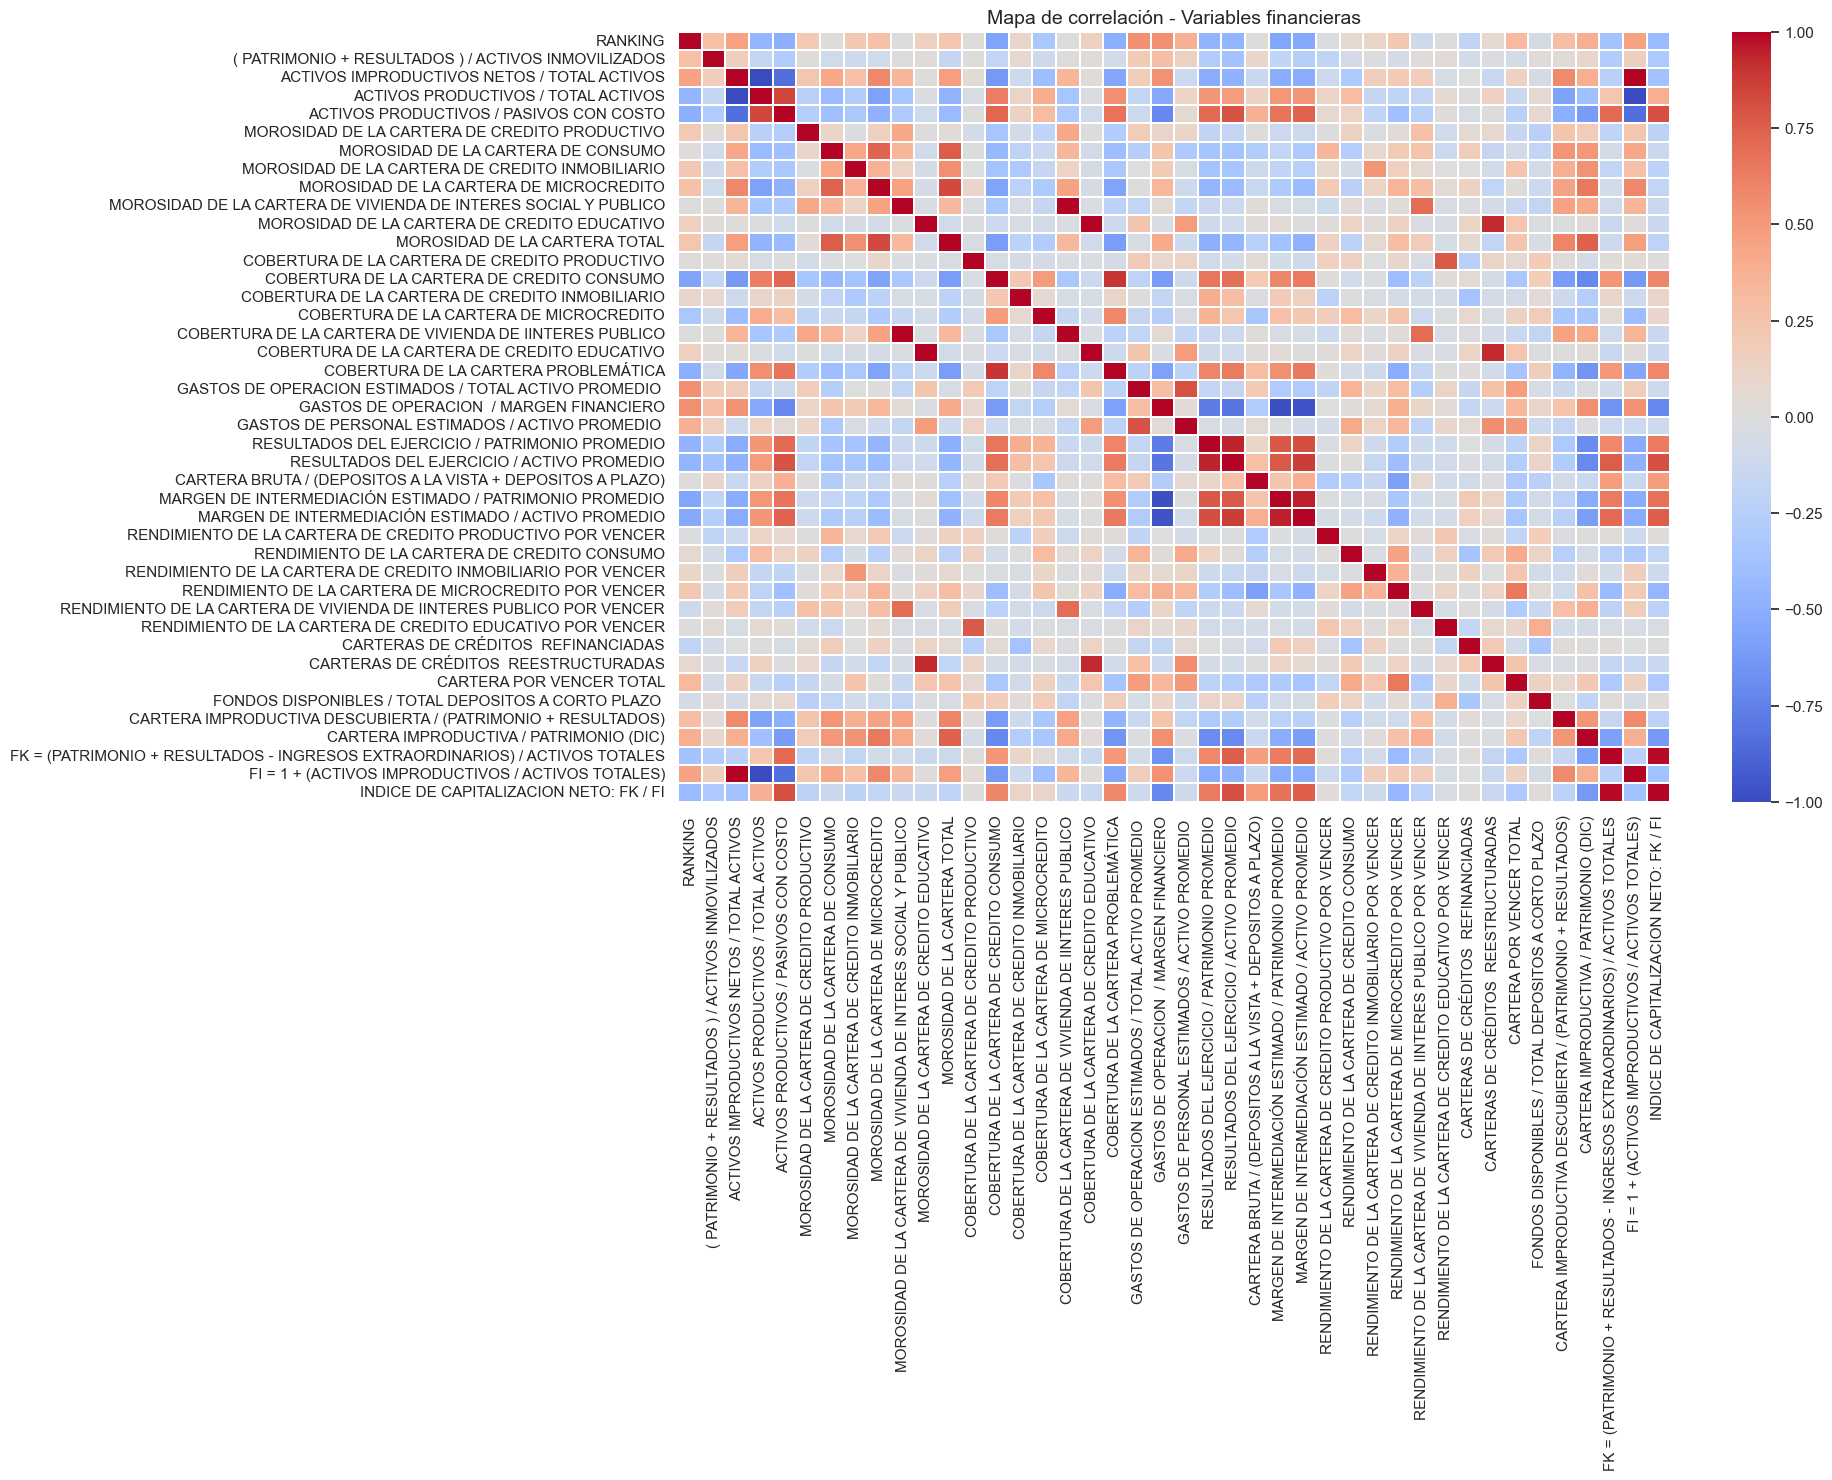


TOP correlaciones más fuertes:

MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO              COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO                        1.000000
MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO                                 COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO                                   1.000000
ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS                                  FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES)                             1.000000
FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES  INDICE DE CAPITALIZACION NETO: FK / FI                                         0.987701
MARGEN DE INTERMEDIACIÓN ESTIMADO / PATRIMONIO PROMEDIO                      MARGEN DE INTERMEDIACIÓN ESTIMADO / ACTIVO PROMEDIO                            0.950554
RESULTADOS DEL EJERCICIO / PATRIMONIO PROMEDIO                               RESULTADOS DEL EJERCICIO / ACTIVO PROMEDIO                       

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_num[num_cols].corr()

plt.figure(figsize=(16,10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Mapa de correlación - Variables financieras", fontsize=14)
plt.show()

# Top correlaciones absolutas
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)

print("\nTOP correlaciones más fuertes:\n")
print(corr_pairs.head(25))


### Eliminación de correlaciones

Se eliminan variables altamente correlacionadas para reducir redundancia y evitar problemas estadísticos y de modelado. Breve motivo y efectos:
No se eliminan variables con correlacion negativa

In [5]:
vars_drop_corr = [
    'MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO',
    'MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO',
    'ACTIVOS IMPRODUCTIVOS NETOS / TOTAL ACTIVOS',
    'FK = (PATRIMONIO + RESULTADOS - INGRESOS EXTRAORDINARIOS) / ACTIVOS TOTALES',
    'MARGEN DE INTERMEDIACIÓN ESTIMADO / PATRIMONIO PROMEDIO',
    'RESULTADOS DEL EJERCICIO / PATRIMONIO PROMEDIO',
    'MOROSIDAD DE LA CARTERA DE MICROCREDITO'
]

df_reducido = df_num.drop(columns=vars_drop_corr)
print("Shape después de reducir:", df_reducido.shape)


Shape después de reducir: (42, 39)


Eliminamos columnas que nos nos sirve dentro del analisis

In [6]:
import numpy as np

# 1) Convertir todo a numerico
df_clean = df_reducido.apply(pd.to_numeric, errors="coerce")

# 2) Reemplazar infinitos por NaN
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

# 3) Eliminar columnas con demasiados NaN
df_clean = df_clean.dropna(axis=1, thresh=int(0.80*len(df_clean)))  # deja columnas con 80%+ datos válidos

# 4) Eliminar filas que aún tengan NaN
df_clean = df_clean.dropna()

#imprimir nombre de columnas eliminadas
cols_eliminadas = set(df_reducido.columns) - set(df_clean.columns)
print("Columnas eliminadas por demasiados NaN:", cols_eliminadas)
for col in cols_eliminadas:
    print("-", col)

print("Shape final para VIF:", df_clean.shape)
df_clean.head()


Columnas eliminadas por demasiados NaN: {'CALIFICADORA', 'SEGMENTO', 'CALIFICACIÓN', 'INSTITUCIÓN'}
- CALIFICADORA
- SEGMENTO
- CALIFICACIÓN
- INSTITUCIÓN
Shape final para VIF: (42, 35)


,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,...,RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,1,-233.715,0.975,1.282,0.030,0.072,0.056,0.111,3.323,1.650,...,0.0,0.0,0.166,0.190,0.161,0.374,0.000,0.311,1.025,0.197
1,2,2.184,0.927,1.040,0.055,0.089,0.023,0.099,1.000,1.108,...,0.0,0.0,0.146,0.137,0.151,0.278,0.157,0.857,1.073,0.079
2,2,0.600,0.807,0.913,0.000,0.067,0.066,0.073,0.000,1.150,...,0.0,0.0,0.154,0.170,0.147,0.359,0.000,0.450,1.193,0.079
3,2,1.648,0.905,1.046,0.000,0.041,0.000,0.075,0.000,1.365,...,0.0,0.0,0.130,0.133,0.155,0.349,0.000,0.482,1.095,0.092
4,2,11.282,0.958,1.317,0.000,0.013,0.000,0.013,0.000,2.206,...,0.0,0.0,0.116,0.112,0.118,0.345,0.000,0.043,1.042,0.234


## VIF

Qué significa VIF y cómo interpretarlo:

VIF mide multicolinealidad: VIF ≈ 1 (sin colinealidad), VIF > 5 (posible preocupación), VIF ≥ 10 (colinealidad alta, problema serio).
Se usa aquí para decidir qué variables conservar antes del PCA/clustering (más adelante el notebook filtra VIF <= 10).

El Variance Inflation Factor (VIF) mide multicolinealidad en regresiones lineales.
Sirve cuando:

Tu modelo predice una variable target

La multicolinealidad distorsiona los coeficientes

Quieres interpretar coeficientes lineales

PERO tú estás haciendo CLUSTERING.
Y en clustering:

👉 NO EXISTE una variable objetivo

👉 NO interpretas coeficientes
👉 NO afecta la capacidad del modelo para separar grupos
👉 Los algoritmos de clustering toleran multicolinealidad

In [7]:
# instalar statsmodels si no está presente (usa el magic %pip para notebooks)

%pip install statsmodels --quiet

from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_clean.copy()

vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_sorted = vif.sort_values("VIF", ascending=False)
vif_sorted



Note: you may need to restart the kernel to use updated packages.


,variable,VIF
2,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,67510.304892
33,FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTA...,1738.858932
3,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,839.195934
14,COBERTURA DE LA CARTERA PROBLEMÁTICA,553.850817
20,MARGEN DE INTERMEDIACIÓN ESTIMADO / ACTIVO PRO...,414.939646
34,INDICE DE CAPITALIZACION NETO: FK / FI,242.402974
15,GASTOS DE OPERACION ESTIMADOS / TOTAL ACTIVO P...,232.103549
17,GASTOS DE PERSONAL ESTIMADOS / ACTIVO PROMEDIO,217.945975
18,RESULTADOS DEL EJERCICIO / ACTIVO PROMEDIO,192.782407
16,GASTOS DE OPERACION / MARGEN FINANCIERO,176.909398


In [8]:
# Seleccionar variables con VIF <= 10 (aceptables)


variables_finales = vif[vif["VIF"] <= 10]["variable"].values

df_final = df_clean[variables_finales]
df_final.shape, df_final.columns

df_final




,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO,COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO,RENDIMIENTO DE LA CARTERA DE CREDITO PRODUCTIVO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO CONSUMO,RENDIMIENTO DE LA CARTERA DE CREDITO INMOBILIARIO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO
0,1,-233.715,0.030,0.056,1.622,0.000,0.108,0.149,0.101,0.000,0.374
1,2,2.184,0.055,0.023,1.051,0.000,0.084,0.138,0.094,0.000,0.278
2,2,0.600,0.000,0.066,1.014,0.000,0.000,0.143,0.105,0.000,0.359
3,2,1.648,0.000,0.000,563.808,0.000,0.000,0.122,0.082,0.000,0.349
4,2,11.282,0.000,0.000,0.000,0.000,0.000,0.117,0.000,0.000,0.345
5,2,12.343,0.016,0.013,1.212,0.000,0.097,0.147,0.096,0.000,0.434
6,2,7.345,0.000,0.011,1.582,0.000,0.000,0.154,0.100,0.000,0.344
7,2,2.400,0.016,0.027,1.135,0.000,0.103,0.136,0.096,0.000,0.365
8,2,-22.964,0.087,0.035,1.004,0.000,0.097,0.142,0.092,0.000,0.492
9,2,2.254,0.002,0.053,0.977,0.000,0.103,0.154,0.104,0.000,0.323


Buscamos variables que tenga un solo un dato y las eliminamos

Exploramos variables que tenga mucha varianza

In [9]:

# --- 1. Porcentaje de ceros por variable ---
percent_zeros = (df_clean == 0).mean() * 100

# --- 2. Varianza por variable ---
variances = df_clean.var()

# --- 3. Unir todo en un mismo DataFrame ---
constant_check = pd.DataFrame({
    "percent_zeros": percent_zeros,
    "variance": variances
}).sort_values("percent_zeros", ascending=False)

# Mostrar el top
constant_check


,percent_zeros,variance
COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO,97.619048,0.023810
COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO,97.619048,0.000390
RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,95.238095,0.000301
RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,95.238095,0.000112
CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),66.666667,0.074602
COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,45.238095,43527.428158
MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,45.238095,0.026708
RENDIMIENTO DE LA CARTERA DE CREDITO PRODUCTIVO POR VENCER,40.476190,0.002484
MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,23.809524,0.001440
CARTERAS DE CRÉDITOS REFINANCIADAS,19.047619,0.006571


Dado que las variables de COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO y COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO. 

Tiene unicamente un dato en la columna la eliminamos

In [10]:
# Eliminar columnas específicas si existen (evita usar drop por index)
cols_to_drop = [
    'COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO',
    'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO'
]

removed = []
for c in cols_to_drop:
    if c in df_clean.columns:
        df_clean.drop(columns=c, inplace=True)
        removed.append(c)

print(f"Columnas eliminadas: {removed}" if removed else "No se eliminaron columnas (no estaban presentes)")
print("Shape final después de eliminar columnas:", df_clean.shape)
df_clean.head()

Columnas eliminadas: ['COBERTURA DE LA CARTERA DE CREDITO EDUCATIVO', 'COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO']
Shape final después de eliminar columnas: (42, 33)


,RANKING,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,...,RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,1,-233.715,0.975,1.282,0.030,0.072,0.056,0.111,3.323,1.650,...,0.0,0.0,0.166,0.190,0.161,0.374,0.000,0.311,1.025,0.197
1,2,2.184,0.927,1.040,0.055,0.089,0.023,0.099,1.000,1.108,...,0.0,0.0,0.146,0.137,0.151,0.278,0.157,0.857,1.073,0.079
2,2,0.600,0.807,0.913,0.000,0.067,0.066,0.073,0.000,1.150,...,0.0,0.0,0.154,0.170,0.147,0.359,0.000,0.450,1.193,0.079
3,2,1.648,0.905,1.046,0.000,0.041,0.000,0.075,0.000,1.365,...,0.0,0.0,0.130,0.133,0.155,0.349,0.000,0.482,1.095,0.092
4,2,11.282,0.958,1.317,0.000,0.013,0.000,0.013,0.000,2.206,...,0.0,0.0,0.116,0.112,0.118,0.345,0.000,0.043,1.042,0.234


## PCA (reducción dimensional y visualización)

Varianza explicada por componente:
PC1: 16.97%
PC2: 15.37%
PC3: 12.82%


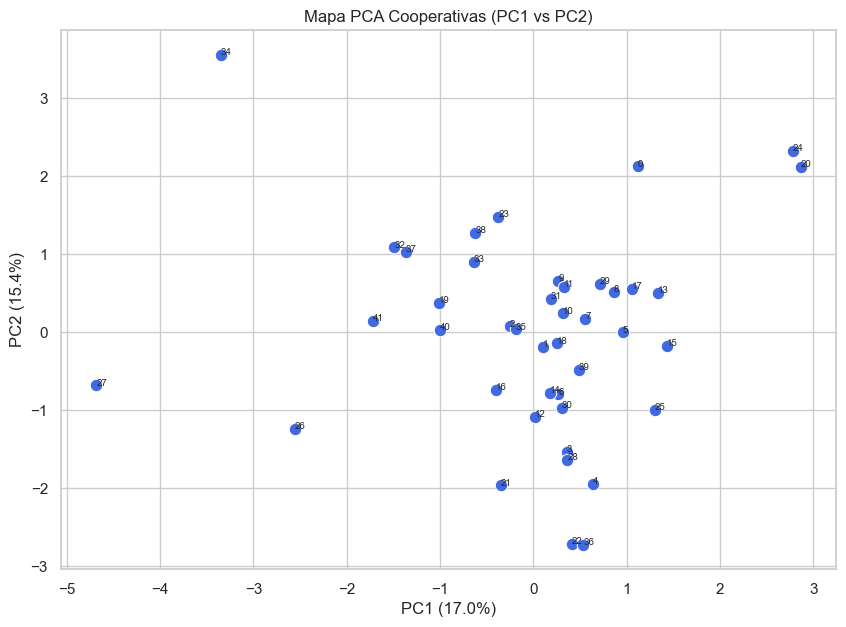

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final)

# 2) PCA con 3 componentes
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(pca_result, columns=['PC1','PC2','PC3'], index=df_final.index)

# 3) Varianza explicada
exp = pca.explained_variance_ratio_ * 100
print("Varianza explicada por componente:")
for i,v in enumerate(exp):
    print(f"PC{i+1}: {v:.2f}%")

# 4) Plot en 2D
plt.figure(figsize=(10,7))
sns.scatterplot(x=df_pca.PC1, y=df_pca.PC2, s=80, color="royalblue")
for i in df_pca.index:
    plt.text(df_pca.PC1[i], df_pca.PC2[i], i, fontsize=7)
plt.title("Mapa PCA Cooperativas (PC1 vs PC2)")
plt.xlabel(f"PC1 ({exp[0]:.1f}%)")
plt.ylabel(f"PC2 ({exp[1]:.1f}%)")
plt.grid(True)
plt.show()


TSNE

# Clustering

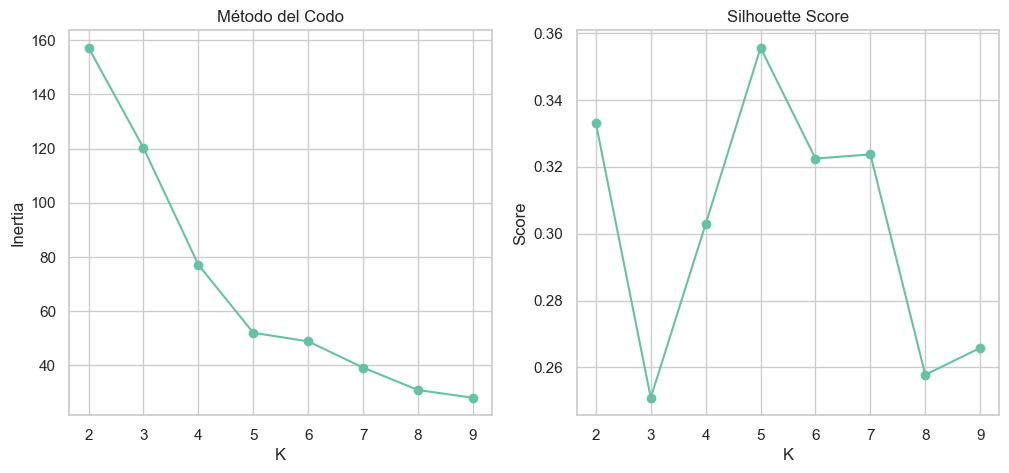

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X_pca = df_pca[['PC1','PC2','PC3']]  # usamos 3 principales

distortions = []
sil = []
K = range(2,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    distortions.append(kmeans.inertia_)
    sil.append(silhouette_score(X_pca, kmeans.labels_))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, distortions, marker='o')
plt.title("Método del Codo")
plt.xlabel("K")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil, marker='o')
plt.title("Silhouette Score")
plt.xlabel("K")
plt.ylabel("Score")

plt.show()


K-means

In [13]:
k_optimo = 4  # (cuando ejecutes veremos cuál te da mejor resultado)

kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_pca["Cluster"] = kmeans.fit_predict(X_pca)

df_pca.head()


,PC1,PC2,PC3,Cluster
0,1.122748,2.123977,0.489752,0
1,0.100689,-0.190720,-0.289195,2
2,-0.254689,0.073817,-0.927570,2
3,0.358473,-1.530525,-1.450728,2
4,0.642805,-1.947414,-1.037882,2


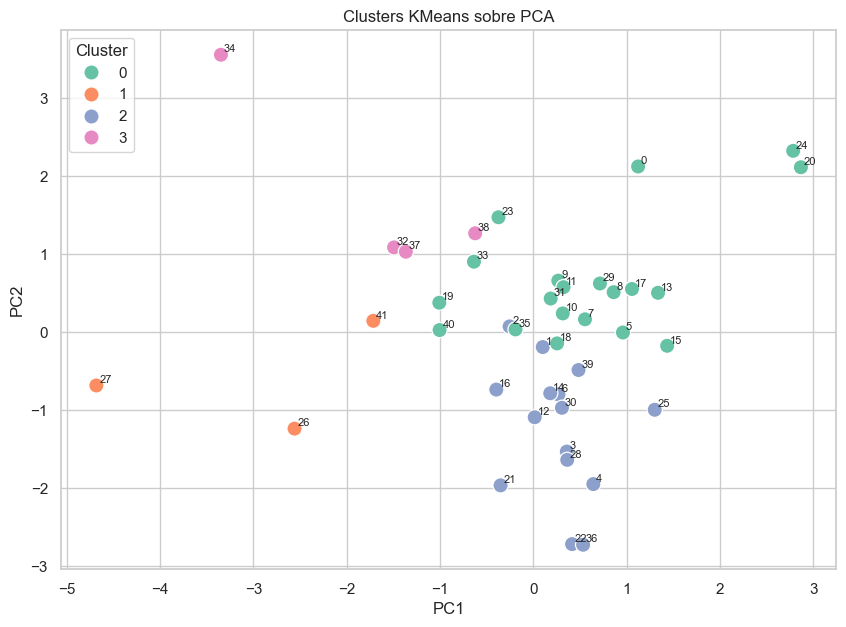

In [14]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="Set2", s=120)

for i in df_pca.index:
    plt.text(df_pca.PC1[i]+0.03, df_pca.PC2[i]+0.03, str(i), fontsize=8)

plt.title("Clusters KMeans sobre PCA")
plt.show()


Resumen por cluster

In [15]:
resumen_clusters = df_final.join(df_pca["Cluster"]).groupby("Cluster").mean()
print(resumen_clusters.T)  # para ver variables como filas


Cluster                                                   0         1  \
RANKING                                             2.80000  4.000000   
( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZ... -9.51250  0.919667   
MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO       0.03935  0.611000   
MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO     0.04075  0.042000   
COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO     1.05530  0.340667   
COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES...  0.00000  0.042667   
RENDIMIENTO DE LA CARTERA DE CREDITO PRODUCTIVO...  0.09020  0.041000   
RENDIMIENTO DE LA CARTERA DE CREDITO CONSUMO        0.14795  0.149000   
RENDIMIENTO DE LA CARTERA DE CREDITO INMOBILIAR...  0.09855  0.096000   
RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO ...  0.00800  0.000000   
FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PL...  0.43150  0.282667   

Cluster                                                      2        3  
RANKING                                          

In [16]:
# Resumen estadístico por cluster (para interpretación)
cluster_profile = df_final.join(df_pca["Cluster"]).groupby("Cluster").mean().T
cluster_profile


Cluster,0,1,2,3
RANKING,2.80000,4.000000,2.800000,4.00000
( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,-9.51250,0.919667,4.554600,1.17425
MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,0.03935,0.611000,0.019600,0.00125
MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,0.04075,0.042000,0.009467,0.11600
COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO,1.05530,0.340667,689.983533,0.51550
COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO,0.00000,0.042667,0.000000,0.00000
RENDIMIENTO DE LA CARTERA DE CREDITO PRODUCTIVO POR VENCER,0.09020,0.041000,0.020400,0.03500
RENDIMIENTO DE LA CARTERA DE CREDITO CONSUMO,0.14795,0.149000,0.142933,0.13175
RENDIMIENTO DE LA CARTERA DE CREDITO INMOBILIARIO POR VENCER,0.09855,0.096000,0.077200,0.18950
RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,0.00800,0.000000,0.000000,0.00000


In [17]:
# cluster_profile: filas = variables, columnas = clusters
print(cluster_profile)

for cluster in cluster_profile.columns:
    print(f"\n📍 Perfil Cluster {cluster}:")
    c = cluster_profile[cluster]  # Serie: índice = variables, valores = media en ese cluster

    for variable, valor in c.items():
        # media global de esa variable (promedio entre clusters)
        media_global = cluster_profile.loc[variable].mean()

        estado = "alto" if valor > media_global else "bajo"
        print(f" - {variable}: {estado} (cluster: {valor:.3f}, global: {media_global:.3f})")


Cluster                                                   0         1  \
RANKING                                             2.80000  4.000000   
( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZ... -9.51250  0.919667   
MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO       0.03935  0.611000   
MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO     0.04075  0.042000   
COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO     1.05530  0.340667   
COBERTURA DE LA CARTERA DE VIVIENDA DE IINTERES...  0.00000  0.042667   
RENDIMIENTO DE LA CARTERA DE CREDITO PRODUCTIVO...  0.09020  0.041000   
RENDIMIENTO DE LA CARTERA DE CREDITO CONSUMO        0.14795  0.149000   
RENDIMIENTO DE LA CARTERA DE CREDITO INMOBILIAR...  0.09855  0.096000   
RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO ...  0.00800  0.000000   
FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PL...  0.43150  0.282667   

Cluster                                                      2        3  
RANKING                                          

In [18]:
# Guardar asignación de clusters
df_resultado = df_final.copy()
df_resultado["Cluster"] = df_pca["Cluster"]

df_resultado.to_csv("cooperativas_clusters_final.csv", index=False)
print("Archivo exportado ✔")


Archivo exportado ✔


In [19]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [20]:
import plotly.express as px

fig = px.line_polar(
    cluster_profile.reset_index(),
    r="value", theta="variable", color="Cluster",
    line_close=True
)
fig.show()


ValueError: Value of 'r' is not the name of a column in 'data_frame'. Expected one of ['index', 0, 1, 2, 3] but received: value

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)  # df_scaled es tu dataset estandarizado


In [22]:
# df: original con INSTITUCIÓN, CALIFICACIÓN, RANKING, etc.
# df_pca: resultado del PCA con la columna "Cluster"

# Asegurarnos de que los índices coinciden
print(df.shape[0], df_pca.shape[0])  # deberían ser iguales

# Crear dataframe enriquecido con info de cooperativa + cluster
df_coop_clusters = df.copy()
df_coop_clusters["Cluster"] = df_pca["Cluster"].values

df_coop_clusters[["INSTITUCIÓN", "CALIFICACIÓN", "RANKING", "Cluster"]]


42 42


,INSTITUCIÓN,CALIFICACIÓN,RANKING,Cluster
0,PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,AAA,1,0
1,29 DE OCTUBRE LTDA,AA,2,2
2,ANDALUCIA LIMITADA,AA,2,2
3,ALIANZA DEL VALLE LIMITADA,AA,2,2
4,DE LOS\r\nSERVIDORES PUBLICOS DEL MINISTERIO D...,AA,2,2
5,RIOBAMBA LTDA,AA,2,0
6,PEQUEÑA EMPRESA DE PASTAZA LIMITADA,AA,2,2
7,ATUNTAQUI LIMITADA,AA,2,0
8,JARDIN AZUAYO LIMITADA,AA,2,0
9,JUVENTUD ECUATORIANA PROGRESISTA\r\nLIMITADA,AA,2,0


In [23]:
df_coop_clusters[["INSTITUCIÓN", "CALIFICACIÓN", "RANKING", "Cluster"]]


,INSTITUCIÓN,CALIFICACIÓN,RANKING,Cluster
0,PEQUEÑA EMPRESA DE COTOPAXI LIMITADA,AAA,1,0
1,29 DE OCTUBRE LTDA,AA,2,2
2,ANDALUCIA LIMITADA,AA,2,2
3,ALIANZA DEL VALLE LIMITADA,AA,2,2
4,DE LOS\r\nSERVIDORES PUBLICOS DEL MINISTERIO D...,AA,2,2
5,RIOBAMBA LTDA,AA,2,0
6,PEQUEÑA EMPRESA DE PASTAZA LIMITADA,AA,2,2
7,ATUNTAQUI LIMITADA,AA,2,0
8,JARDIN AZUAYO LIMITADA,AA,2,0
9,JUVENTUD ECUATORIANA PROGRESISTA\r\nLIMITADA,AA,2,0


## APRENDIZAJE SEMISUPERVISADO

In [ ]:
!pip install imbalanced-learn


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, confusion_matrix, roc_auc_score
)

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# --------------------------------------------
# 1) Fusionar clases B y BB → Clase "B"
# --------------------------------------------
df["CALIFICACION_FUSION"] = df["CALIFICACIÓN"].replace({"BB": "B"})

# Orden manual para garantizar menor clase
orden_labels = ["AAA", "AA", "A", "BBB","B"]  
le = LabelEncoder()
le.fit(orden_labels)

y_raw = df["CALIFICACION_FUSION"].values
y = le.transform(y_raw)


# --------------------------------------------
# 2) Features finales (reutilizar df_clean)
# --------------------------------------------


X = df_clean.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

classes = np.unique(y)
print("Clases finales:", le.inverse_transform(classes))
df_clean.head()




Clases finales: ['A' 'AA' 'AAA' 'B' 'BBB']


,( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILIZADOS,ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS,ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO,MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO,MOROSIDAD DE LA CARTERA DE CONSUMO,MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO,MOROSIDAD DE LA CARTERA TOTAL,COBERTURA DE LA CARTERA DE CREDITO PRODUCTIVO,COBERTURA DE LA CARTERA DE CREDITO CONSUMO,COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO,...,RENDIMIENTO DE LA CARTERA DE VIVIENDA DE IINTERES PUBLICO POR VENCER,RENDIMIENTO DE LA CARTERA DE CREDITO EDUCATIVO POR VENCER,CARTERAS DE CRÉDITOS REFINANCIADAS,CARTERAS DE CRÉDITOS REESTRUCTURADAS,CARTERA POR VENCER TOTAL,FONDOS DISPONIBLES / TOTAL DEPOSITOS A CORTO PLAZO,CARTERA IMPRODUCTIVA DESCUBIERTA / (PATRIMONIO + RESULTADOS),CARTERA IMPRODUCTIVA / PATRIMONIO (DIC),FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTALES),INDICE DE CAPITALIZACION NETO: FK / FI
0,-233.715,0.975,1.282,0.030,0.072,0.056,0.111,3.323,1.650,1.622,...,0.0,0.0,0.166,0.190,0.161,0.374,0.000,0.311,1.025,0.197
1,2.184,0.927,1.040,0.055,0.089,0.023,0.099,1.000,1.108,1.051,...,0.0,0.0,0.146,0.137,0.151,0.278,0.157,0.857,1.073,0.079
2,0.600,0.807,0.913,0.000,0.067,0.066,0.073,0.000,1.150,1.014,...,0.0,0.0,0.154,0.170,0.147,0.359,0.000,0.450,1.193,0.079
3,1.648,0.905,1.046,0.000,0.041,0.000,0.075,0.000,1.365,563.808,...,0.0,0.0,0.130,0.133,0.155,0.349,0.000,0.482,1.095,0.092
4,11.282,0.958,1.317,0.000,0.013,0.000,0.013,0.000,2.206,0.000,...,0.0,0.0,0.116,0.112,0.118,0.345,0.000,0.043,1.042,0.234


Se prepara el conjunto de datos para la parte de aprendizaje semisupervisado. Primero se fusionan las clases B y BB en una sola categoría B, creando la columna CALIFICACION_FUSION. Luego se define un orden explícito de los ratings (AAA, AA, A, BBB, B) y se codifican estas etiquetas a valores numéricos usando LabelEncoder, garantizando un mapeo fijo entre nombre de clase y entero. A continuación se reutiliza el df_clean de la parte 1, eliminando la columna RANKING para evitar usarla como predictor, y se extrae la matriz de características X. Estas variables se escalan con StandardScaler para trabajar en un espacio normalizado, que es el que se utilizará en todos los modelos. Finalmente, se imprime el conjunto de clases finales presentes en los datos, ya mapeadas de vuelta a sus nombres originales.

In [97]:
def gaussian_augment_one_sample(X_class, n_new=3, noise_factor=0.05, random_state=0):
    """Aumenta una clase con UNA sola muestra usando ruido gaussiano."""
    rng = np.random.RandomState(random_state) # se crea un generador de números aletorios con una semilla fija
    base = X_class[0] 
    std = X_class.std(axis=0) + 1e-6  # se calcula la desviación estándar por columna. como solo hay 1 muestra es 0 y se le suma una cota inferior
    new_samples = base + rng.normal(0, noise_factor * std, size=(n_new, len(base)))
    # Se genera una matriz de tamaño n_new, d de reuido gaussiano
    # Cada entrada se toma de una distribución normal
    return new_samples
    #new_samples es un array (n_new, d) 
    # con nuevos puntos sintéticos de esa clase, 
    # generados como vecinos cercanos de la única muestra
    # real usando un ruido gaussiano pequeño.


Para las clases que solo tienen una observación real, se generan datos sintéticos usando ruido gaussiano. La idea es tomar el vector original de esa muestra y crear varias copias muy parecidas, pero con pequeñas perturbaciones aleatorias en cada atributo. Esas perturbaciones se sacan de una distribución normal (campana de Gauss) con media 0 y una desviación muy pequeña, controlada por el parámetro noise_factor. Además, se agrega una cota mínima a la desviación para evitar que el ruido sea exactamente 0.

De esta forma, los nuevos ejemplos quedan cerca del punto original en el espacio de características, mantienen su “forma” general, pero no son idénticos. Esto ayuda a que las clases con una sola muestra no queden totalmente invisibles para el modelo y puedan participar mejor en el entrenamiento.

In [98]:
def augment_train(X, y, min_samples=4, random_state=0):
    """
    Reglas:
    - Si una clase tiene >= 2 muestras: usar SMOTE
    - Si una clase tiene SOLO 1 muestra: usar Gaussian augmentation primero
    """

    X_aug = X.copy()
    y_aug = y.copy()

    classes, counts = np.unique(y, return_counts=True)

    # ---- PASO 1: Resolver clases con 1 sola muestra ----
    for cls, cnt in zip(classes, counts):
        if cnt == 1:
            idx = np.where(y == cls)[0]
            X_class = X[idx]
            X_new = gaussian_augment_one_sample(X_class, n_new=min_samples - 1,
                                                random_state=random_state)
            y_new = np.full(len(X_new), cls)
            X_aug = np.vstack([X_aug, X_new])
            y_aug = np.concatenate([y_aug, y_new])

    # ---- PASO 2: Aplicar SMOTE si es posible ----
    # verificar si hay clases con ≥2 muestras
    cls, cnts = np.unique(y_aug, return_counts=True)
    if np.all(cnts >= 2):
        sm = SMOTE(sampling_strategy="not majority", k_neighbors=1,
                   random_state=random_state)
        X_aug, y_aug = sm.fit_resample(X_aug, y_aug)
    #toma las clases cque tienen menos muestras que la clase mayoritarioa
    # Crea nuevos ejemplos ejemplos crea un vector entre dos ejemplos reales de la misma clase
    #se repite hasta mas o menos igualar el número demuestras
    return X_aug, y_aug


Primero detecta las clases que solo tienen una muestra y, para cada una, genera ejemplos sintéticos cercanos usando ruido gaussiano alrededor de esa única observación (gaussian_augment_one_sample). Con el conjunto ampliado X_aug, y_aug, vuelve a calcular las frecuencias por clase y, siempre que todas tengan al menos 2 muestras, aplica SMOTE (evitando la clase mayoritaria) para generar nuevos ejemplos interpolando entre instancias reales de la misma clase. El resultado es un conjunto etiquetado más balanceado, que se usará para entrenar el Random Forest baseline con mejor soporte en las clases raras.

In [99]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix
)
import numpy as np

def compute_metrics(y_true, y_pred, y_proba, classes):
    """
    Devuelve un diccionario con:
    - Macro F1
    - Balanced Accuracy
    - ROC AUC Macro (si y_proba está disponible)
    - Matriz de confusión
    - F1 por clase
    - Recall por clase (Balanced Accuracy por clase)
    """

    # --- F1 por clase ---
    f1_per_class = f1_score(
        y_true, y_pred,
        labels=classes,
        average=None
    )

    # --- Macro F1 ---
    macro_f1 = f1_score(
        y_true, y_pred,
        labels=classes,
        average="macro"
    )

    # --- Recall por clase (Balanced Acc por clase) ---
    recall_per_class = recall_score(
        y_true, y_pred,
        labels=classes,
        average=None
    )

    # --- Balanced Accuracy global ---
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    # --- Matriz de confusión ---
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # --- ROC AUC macro (si y_proba existe) ---
    try:
        roc_auc = roc_auc_score(
            y_true,
            y_proba,
            multi_class="ovr",
            average="macro"
        )
    except Exception:
        roc_auc = np.nan

    # --- Empaquetar todo en un diccionario ---
    return {
        "macro_f1": macro_f1,
        "balanced_acc": bal_acc,
        "roc_auc_macro": roc_auc,
        "cm": cm,
        "f1_per_class": f1_per_class,
        "recall_per_class": recall_per_class
    }


Esta función centraliza el cálculo de las métricas de evaluación para todos los modelos. A partir de las etiquetas verdaderas y_pred y las probabilidades y_proba, devuelve Macro-F1, Balanced Accuracy global, AUC ROC macro, la matriz de confusión y las métricas por clase (F1 y recall). Esto permite comparar el baseline supervisado y los métodos semisupervisados para cada valor de p y cada repetición.


### Métodos implementados

En esta sección se comparan tres enfoques para predecir el rating de las cooperativas usando distintos niveles de datos etiquetados (p ∈ {0.05, 0.10, 0.20, 0.40, 0.60, 0.80}):

- **Baseline supervisado (Random Forest)**  
  Para cada valor de p se selecciona un subconjunto etiquetado idx_L. Sobre ese conjunto se aplica *data augmentation* (ruido gaussiano para clases con una sola muestra + SMOTE para balancear clases minoritarias) y se entrena un RandomForestClassifier solo con esos datos etiquetados. Luego se evalúa el modelo sobre todo el conjunto de cooperativas para obtener Macro-F1, Balanced Accuracy y AUC.

- **Self-training con Random Forest como clasificador base**  
  Se construye un vector y_semi donde las instancias etiquetadas mantienen su rating real y las no etiquetadas se marcan con -1. Con este vector y el conjunto completo X_scaled se entrena un SelfTrainingClassifier cuyo clasificador base es un Random Forest. El modelo va generando pseudolabels para las instancias no etiquetadas siempre que la probabilidad máxima supere un umbral de confianza τ, probado en varios valores (τ ∈ {0.5, 0.6, 0.7, 0.8, 0.9}), y reentrena iterativamente hasta estabilizarse.

- **Label Propagation y Label Spreading sobre grafo k-NN**  
  Para cada algoritmo (LabelPropagation y LabelSpreading) y para cada k en k ∈ {5, 10, 15, 20, 30}, se construye nuevamente un vector y_semi con etiquetas reales en idx_L y -1 en el resto. El modelo usa kernel="knn" y n_neighbors=k para construir un grafo k-NN en el espacio de características escalado (X_scaled), utilizando la distancia euclidiana por defecto. A partir de ese grafo, se propagan las etiquetas desde las instancias etiquetadas hacia las no etiquetadas, obteniendo predicciones finales y distribuciones de probabilidad por clase para evaluar su desempeño.



In [ ]:
ps = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80]
n_reps = 10
base_seed = 123

taus = [0.5, 0.6, 0.7, 0.8, 0.9]
ks = [5, 10, 15, 20, 30]

N = X_scaled.shape[0]
results = []

# - ps: fracciones de datos etiquetados (p ∈ {5%, 10%, 20%, 40%, 60%, 80%}).
# - n_reps: número de repeticiones aleatorias por cada p.
# - taus: umbrales de confianza para self-training.
# - ks: números de vecinos para los métodos de propagación de etiqueta

# =========================================================
# FIJAR ÍNDICES PARA CLASES RARAS: AAA y B
# =========================================================
fixed_L_base = []
class_names = le.classes_
classes = np.unique(y)

# AAA
idx_label_AAA = np.where(class_names == 'AAA')[0]
if idx_label_AAA.size > 0:
    label_AAA = idx_label_AAA[0]
    idx_AAA = np.where(y == label_AAA)[0]
    if idx_AAA.size > 0:
        fixed_L_base.append(idx_AAA[0])

# B
idx_label_B = np.where(class_names == 'B')[0]
if idx_label_B.size > 0:
    label_B = idx_label_B[0]
    idx_B = np.where(y == label_B)[0]
    if idx_B.size > 0:
        fixed_L_base.append(idx_B[0])

fixed_L_base = np.array(fixed_L_base, dtype=int)
print("Índices fijos (AAA y B):", fixed_L_base)
print("Clases:", le.inverse_transform(y[fixed_L_base]))

# =========================================================
# LOOP PRINCIPAL SOBRE p
# =========================================================
# En este bucle, para cada fracción etiquetada p y repetición se construye
# un subconjunto etiquetado L y su complemento no etiquetado U a partir del
# conjunto total T. L siempre incluye al menos un ejemplo de las clases raras
# (AAA y B) y, cuando es posible, se completa de forma estratificada, 
# garantizando que haya al menos dos clases distintas antes de seguir.


for p in ps:
    n_labeled = max(1, int(round(p * N)))

    if n_labeled < len(fixed_L_base):
        print(f" Ajustando n_labeled a {len(fixed_L_base)} para cubrir AAA y B.")
        n_labeled = len(fixed_L_base)

    print(f"\n=== p={p:.2f} → {n_labeled} etiquetas ===")

    for rep in range(n_reps):
        rs = base_seed + rep
        idx_all = np.arange(N)

        # -------------------------------------------------------
        # SPLIT GARANTIZANDO >= 2 CLASES Y AAA/B FIJOS
        # -------------------------------------------------------
        max_tries = 50
        for attempt in range(max_tries):

            fixed_L = fixed_L_base
            remaining = np.setdiff1d(idx_all, fixed_L)

            n_extra = n_labeled - len(fixed_L)

            if n_extra > 0:
                y_rem = y[remaining]
                class_counts_rem = np.bincount(y_rem)
                class_counts_rem = class_counts_rem[class_counts_rem > 0]

                can_stratify = (
                    len(class_counts_rem) > 0
                    and min(class_counts_rem) >= 2
                    and n_extra >= len(np.unique(y_rem))
                )

                if can_stratify:
                    idx_extra, idx_U = train_test_split(
                        remaining,
                        train_size=n_extra,
                        stratify=y_rem,
                        random_state=rs + attempt
                    )
                else:
                    idx_extra, idx_U = train_test_split(
                        remaining,
                        train_size=n_extra,
                        random_state=rs + attempt
                    )

                idx_L = np.concatenate([fixed_L, idx_extra])

            else:
                idx_L = fixed_L
                idx_U = remaining

            y_L = y[idx_L]

            if len(np.unique(y_L)) >= 2:
                break

        else:
            print(f" No se pudo obtener ≥2 clases (p={p}, rep={rep}).")
            continue

        # =====================================================
        # CONJUNTO FINAL
        # =====================================================
        # A partir de los índices etiquetados idx_L se extraen las instancias 
        # correspondientes y sus etiquetas. Sobre este subconjunto se calculan pesos 
        # de clase balanceados y se aplica el esquema de data augmentation definido 
        # anteriormente (ruido gaussiano + SMOTE) para incrementar la representación 
        # de las clases minoritarias antes de entrenar el modelo supervisado.

        
        X_L = X_scaled[idx_L]
        y_L = y[idx_L]

        # PESOS DE CLASE
        cw = compute_class_weight("balanced", classes=np.unique(y_L), y=y_L)
        class_weights = dict(zip(np.unique(y_L), cw))

        # DATA AUGMENTATION (solo RF)
        X_L_aug, y_L_aug = augment_train(X_L, y_L, random_state=rs)

        # =====================================================
        # BASELINE RF
        # =====================================================
        rf = RandomForestClassifier(
            n_estimators=300,
            random_state=rs,
            class_weight=class_weights
        )
        rf.fit(X_L_aug, y_L_aug)

        y_pred = rf.predict(X_scaled)
        proba = rf.predict_proba(X_scaled)

        m = compute_metrics(y, y_pred, proba, classes)
        m.update({
            "method": "baseline_rf",
            "p": p,
            "rep": rep,
            "y_proba": proba,   
            "cm": m["cm"],
            "f1_per_class": m["f1_per_class"],
            "recall_per_class": m["recall_per_class"]
        })
        results.append(m)

        # =====================================================
        # SELF-TRAINING
        # =====================================================
        for tau in taus:
            base_rf = RandomForestClassifier(
                n_estimators=300,
                random_state=rs,
                class_weight=class_weights
            )

            y_semi = np.full(N, -1)
            y_semi[idx_L] = y_L

            st = SelfTrainingClassifier(base_rf, threshold=tau)
            st.fit(X_scaled, y_semi)

            y_pred = st.predict(X_scaled)
            proba = st.predict_proba(X_scaled)

            m = compute_metrics(y, y_pred, proba, classes)
            m.update({
                "method": "self_training",
                "tau": tau,
                "p": p,
                "rep": rep,
                "y_proba": proba
            })
            results.append(m)

        # =====================================================
        # LABEL PROPAGATION / SPREADING
        # =====================================================
        for model_name, Algo in [
            ("label_prop", LabelPropagation),
            ("label_spread", LabelSpreading)
        ]:
            for k in ks:
                y_semi = np.full(N, -1)
                y_semi[idx_L] = y_L

                model = Algo(kernel="knn", n_neighbors=k)
                model.fit(X_scaled, y_semi)

                y_pred = model.predict(X_scaled)
                y_proba = getattr(model, "label_distributions_", None)

                if y_proba is None or not np.all(np.isfinite(y_proba)):
                    print(f"NaNs en {model_name} (k={k}, p={p}, rep={rep}).")
                    continue

                m = compute_metrics(y, y_pred, y_proba, classes)
                m.update({
                    "method": model_name,
                    "k": k,
                    "p": p,
                    "rep": rep,
                    "y_proba": y_proba
                })
                results.append(m)

results_df = pd.DataFrame(results)
results_df.head()


Índices fijos (AAA y B): [ 0 40]
Clases: ['AAA' 'B']

=== p=0.05 → 2 etiquetas ===

=== p=0.10 → 4 etiquetas ===

=== p=0.20 → 8 etiquetas ===

=== p=0.40 → 17 etiquetas ===

=== p=0.60 → 25 etiquetas ===

=== p=0.80 → 34 etiquetas ===


,macro_f1,balanced_acc,roc_auc_macro,cm,f1_per_class,recall_per_class,method,p,rep,y_proba,tau,k
0,0.066667,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 5, 10, 0], [0, 0, 1,...","[0.0, 0.0, 0.2222222222222222, 0.1111111111111...","[0.0, 0.0, 1.0, 1.0, 0.0]",baseline_rf,0.05,0,"[[0.99, 0.01], [0.19333333333333333, 0.8066666...",NaN,NaN
1,0.057576,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 7, 8, 0], [0, 0, 1, ...","[0.0, 0.0, 0.16666666666666666, 0.121212121212...","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.9366666666666666, 0.06333333333333334], [0...",0.5,NaN
2,0.100000,0.4,NaN,"[[0, 0, 0, 12, 0], [0, 0, 3, 12, 0], [0, 0, 1,...","[0.0, 0.0, 0.4, 0.1, 0.0]","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.81, 0.19], [0.0, 1.0], [0.0, 1.0], [0.0066...",0.6,NaN
3,0.057576,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 7, 8, 0], [0, 0, 1, ...","[0.0, 0.0, 0.16666666666666666, 0.121212121212...","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.7466666666666667, 0.25333333333333335], [0...",0.7,NaN
4,0.057576,0.4,NaN,"[[0, 0, 1, 11, 0], [0, 0, 7, 8, 0], [0, 0, 1, ...","[0.0, 0.0, 0.16666666666666666, 0.121212121212...","[0.0, 0.0, 1.0, 1.0, 0.0]",self_training,0.05,0,"[[0.7466666666666667, 0.25333333333333335], [0...",0.8,NaN


In [111]:
summary = (
    results_df
    .groupby(["method", "p"], as_index=False)
    .agg(
        macro_f1_mean=("macro_f1", "mean"),
        macro_f1_std=("macro_f1", "std"),
        bal_acc_mean=("balanced_acc", "mean"),
        bal_acc_std=("balanced_acc", "std"),
        auc_mean=("roc_auc_macro", "mean"),
        auc_std=("roc_auc_macro", "std")
    )
    .sort_values(["p", "method"])
)

summary


,method,p,macro_f1_mean,macro_f1_std,bal_acc_mean,bal_acc_std,auc_mean,auc_std
0,baseline_rf,0.05,0.065785,0.006478,0.400000,0.000000,NaN,NaN
6,label_prop,0.05,0.018182,0.000000,0.200000,0.000000,NaN,NaN
12,label_spread,0.05,0.018182,0.000000,0.200000,0.000000,NaN,NaN
18,self_training,0.05,0.104392,0.056902,0.400000,0.000000,NaN,NaN
1,baseline_rf,0.10,0.267551,0.055356,0.542667,0.032841,NaN,NaN
7,label_prop,0.10,0.078924,0.039838,0.207133,0.035977,NaN,NaN
13,label_spread,0.10,0.096753,0.059862,0.241733,0.085924,NaN,NaN
19,self_training,0.10,0.309383,0.071623,0.532333,0.059006,NaN,NaN
2,baseline_rf,0.20,0.445488,0.049841,0.632000,0.060496,0.845158,0.027267
8,label_prop,0.20,0.130914,0.063226,0.228267,0.058159,0.794042,0.040359


In [112]:
m = compute_metrics(y, y_pred, y_proba, classes)

class_names = le.inverse_transform(classes)

df_metrics = pd.DataFrame({
    "Clase": class_names,
    "F1": m["f1_per_class"],
    "BalancedAcc_clase (Recall)": m["recall_per_class"]
})

print("===== MÉTRICAS POR CLASE =====")
display(df_metrics)

print("\n===== PROMEDIOS MACRO =====")
print("Macro F1:", m["macro_f1"])
print("Balanced Accuracy (macro):", m["balanced_acc"])


===== MÉTRICAS POR CLASE =====


,Clase,F1,BalancedAcc_clase (Recall)
0,A,0.45283,1.0
1,AA,0.00000,0.0
2,AAA,0.00000,0.0
3,B,0.00000,0.0
4,BBB,0.00000,0.0



===== PROMEDIOS MACRO =====
Macro F1: 0.09056603773584906
Balanced Accuracy (macro): 0.2


In [113]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mean_confusion(method, p_target):
    """
    Dibuja la matriz de confusión promedio para un método y un valor de p,
    promediando sobre las repeticiones.
    """
    sub = results_df[
        (results_df["method"] == method) &
        (results_df["p"] == p_target)
    ]

    # extraer todas las cms (cada una es un array n_clases x n_clases)
    cms = sub["cm"].dropna().values
    if len(cms) == 0:
        print(f"No hay matrices de confusión para method={method}, p={p_target}")
        return
    
    mean_cm = np.mean(np.stack(cms, axis=0), axis=0)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        mean_cm,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=le.inverse_transform(classes),
        yticklabels=le.inverse_transform(classes)
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Matriz de confusión promedio – {method}, p={p_target}")
    plt.tight_layout()
    plt.show()


Para cada método y fracción etiquetada p, se calculó una matriz de confusión en cada una de las 10 repeticiones. Para resumir el comportamiento por p, se promedió elemento a elemento la matriz de confusión sobre las repeticiones y se reporta esta matriz promedio como “matriz de confusión por p” para cada método.

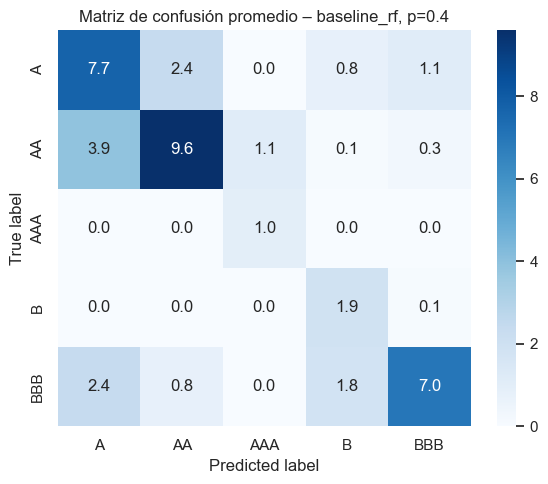

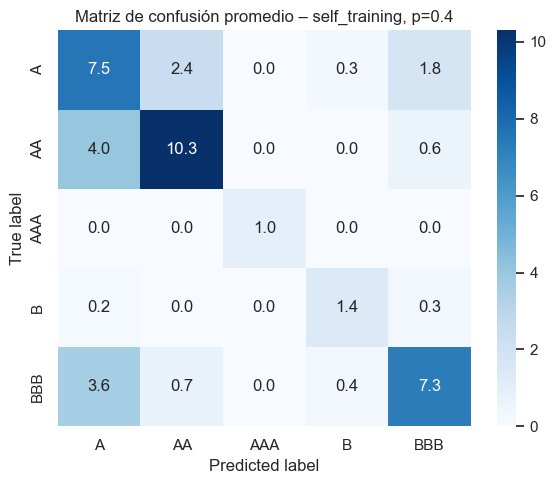

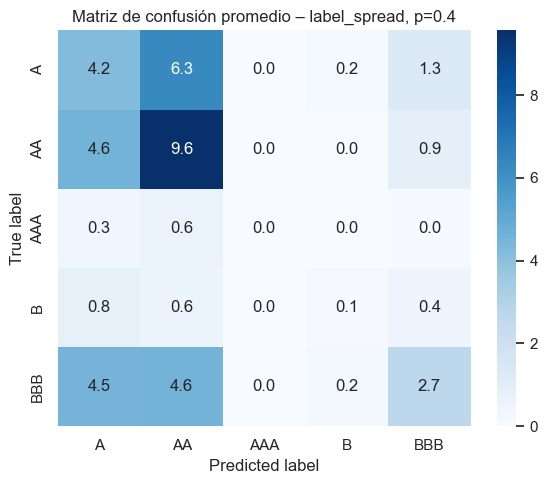

In [114]:
## Ejemplos de uso función plot_mean_confusion
# baseline supervisado con p = 0.40
plot_mean_confusion("baseline_rf", 0.40)

# self-training con p = 0.40
plot_mean_confusion("self_training", 0.40)

# label spreading con p = 0.40
plot_mean_confusion("label_spread", 0.40)



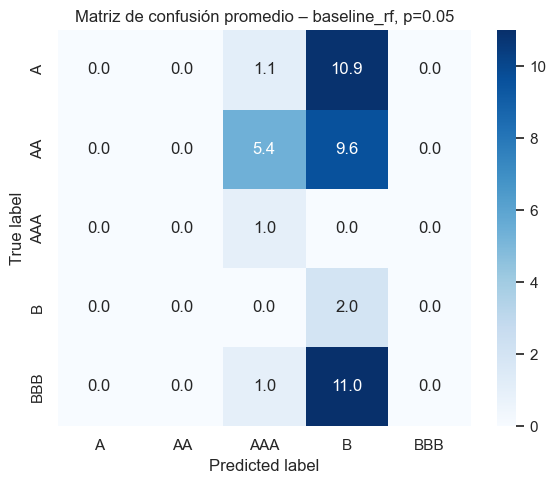

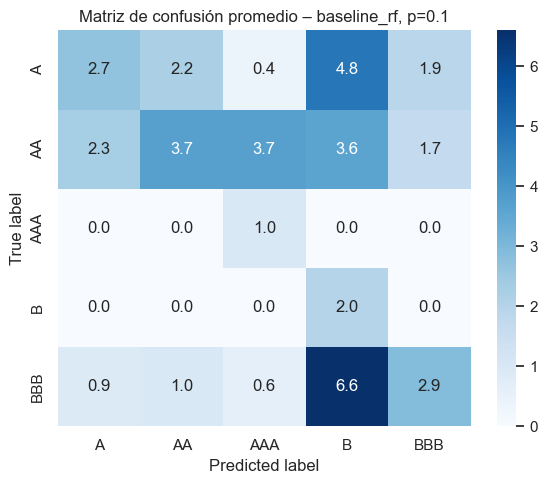

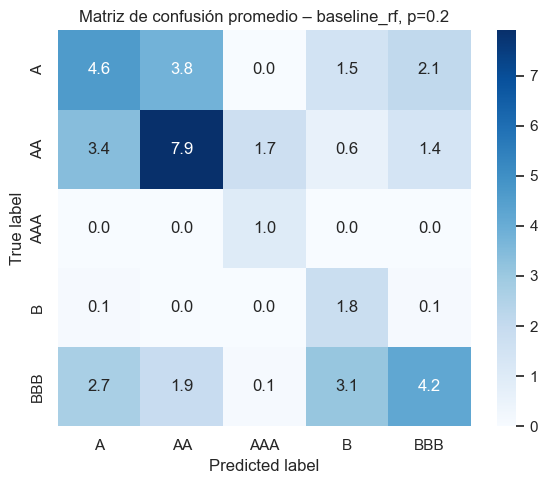

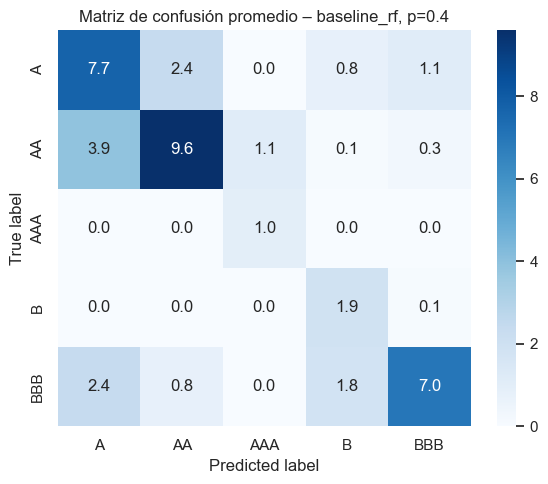

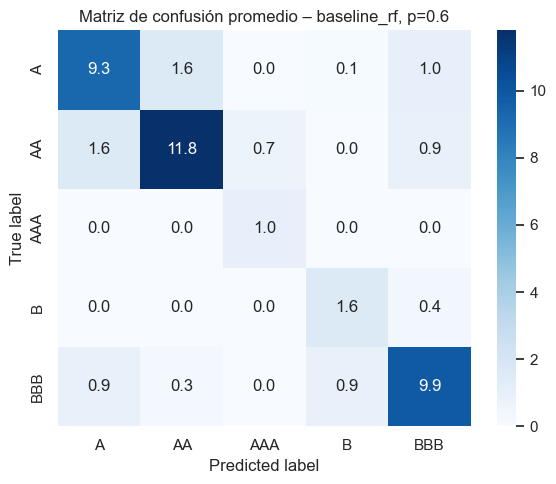

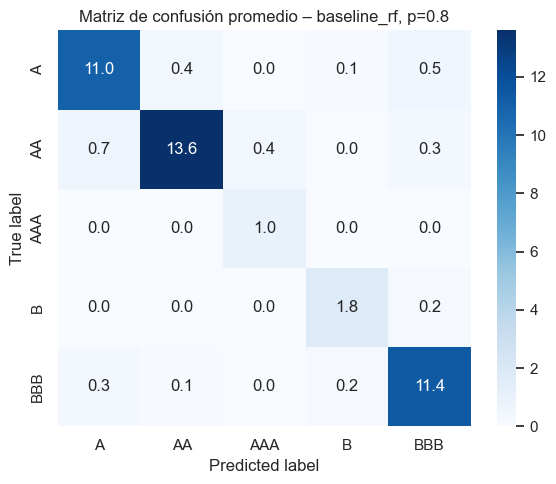

In [115]:
## Ejemplo para todos los p de un modelo
for p_target in ps:
    plot_mean_confusion("baseline_rf", p_target)


In [118]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(method, p_target):
    """
    Dibuja curvas ROC multiclase promedio para un método y un valor de p.
    Repara automáticamente y_proba para que tenga todas las clases.
    Usa One-vs-Rest.
    """
    sub = results_df[
        (results_df["method"] == method) &
        (results_df["p"] == p_target)
    ]

    if len(sub) == 0:
        print(f"No hay resultados para method={method}, p={p_target}")
        return

    plt.figure(figsize=(8, 6))

    classes_int = classes
    class_names = le.inverse_transform(classes_int)

    colors = plt.cm.tab10(np.linspace(0, 1, len(classes_int)))

    for i, cname in enumerate(class_names):
        tprs = []
        aucs = []

        for _, row in sub.iterrows():
            y_true = y
            y_proba = row.get("y_proba", None)

            if y_proba is None or not np.all(np.isfinite(y_proba)):
                continue

            # ---------------------------------------------
            # FIX: reconstruir matriz de probabilidades para 
            # que SIEMPRE tenga todas las clases
            # ---------------------------------------------
            if y_proba.shape[1] != len(classes_int):
                fixed_proba = np.zeros((y_proba.shape[0], len(classes_int)))

                # copiar columnas disponibles
                min_cols = min(y_proba.shape[1], len(classes_int))
                fixed_proba[:, :min_cols] = y_proba[:, :min_cols]

                # clases faltantes quedan en 0.0
                y_proba_fixed = fixed_proba

            else:
                y_proba_fixed = y_proba

            # Binarizar etiquetas verdaderas
            y_bin = label_binarize(y_true, classes=classes_int)

            # Si la clase nunca aparece en y_true → no se puede calcular ROC
            if np.sum(y_bin[:, i]) == 0:
                continue

            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba_fixed[:, i])
            roc_auc = auc(fpr, tpr)

            tprs.append((fpr, tpr))
            aucs.append(roc_auc)

        if len(tprs) == 0:
            print(f"⚠️ No se pudo generar ROC para clase {cname}")
            continue

        # Interpolación para promediar curvas
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr_values = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in tprs]

        mean_tpr = np.mean(mean_tpr_values, axis=0)
        mean_auc = np.mean(aucs)

        plt.plot(mean_fpr, mean_tpr, color=colors[i],
                 label=f"{cname} (AUC={mean_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curvas ROC – {method}, p={p_target}")
    plt.legend()
    plt.grid(True)
    plt.show()


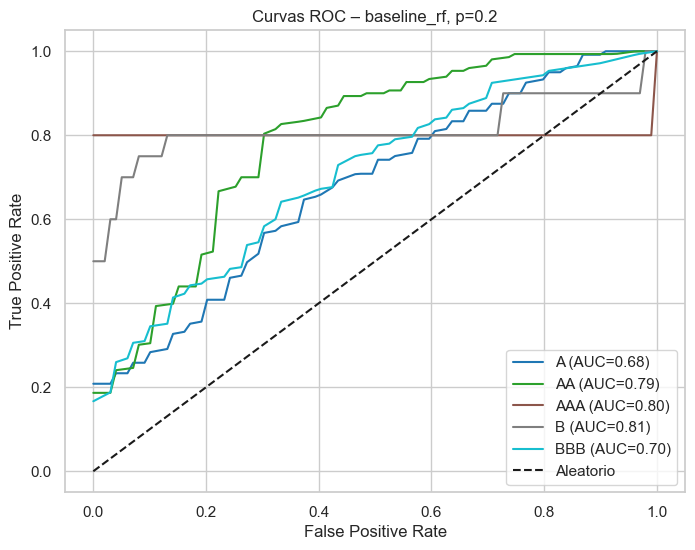

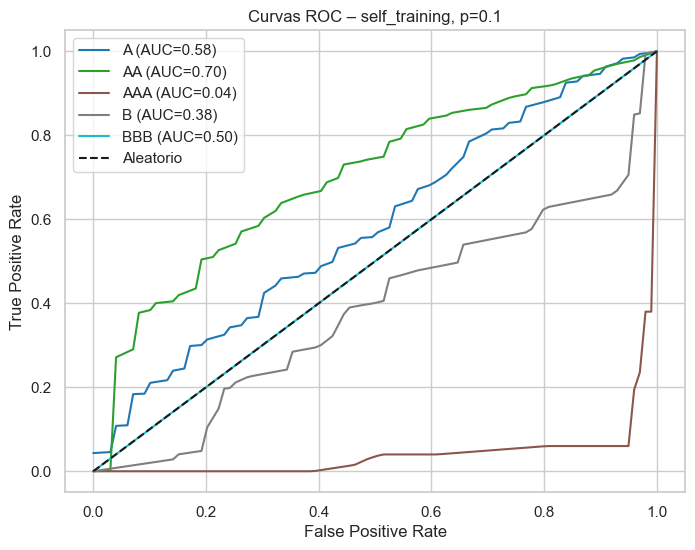

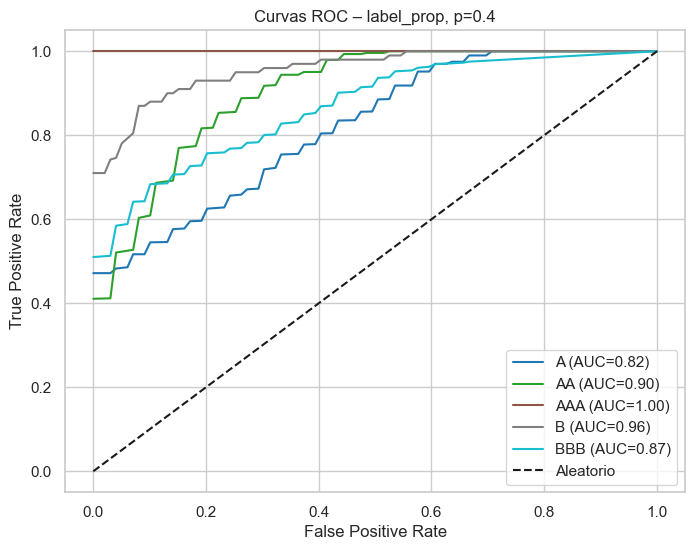

In [119]:
plot_roc_curves("baseline_rf", 0.20)

plot_roc_curves("self_training", 0.10)

plot_roc_curves("label_prop", 0.40)


Aunque la curva ROC muestra un AUC = 1 para la clase AAA en algunos modelos, este valor no indica que el clasificador esté prediciendo correctamente esa clase. En realidad, AAA tiene solo una muestra en todo el dataset y en varios splits no aparece en el conjunto etiquetado, por lo que el modelo no aprende un patrón real para esta categoría. Cuando esto ocurre, el modelo asigna probabilidad 0 a todos los ejemplos, y dado que casi todos los valores verdaderos para AAA también son 0, la curva ROC resultante es degenerada, generando un AUC = 1 por construcción matemática.

In [120]:
# Separar baseline y métodos semisupervisados
base_summary = summary[summary["method"] == "baseline_rf"].rename(
    columns={
        "macro_f1_mean": "base_macro_f1",
        "bal_acc_mean": "base_bal_acc"
    }
)[["p", "base_macro_f1", "base_bal_acc"]]

semi_summary = summary[summary["method"] != "baseline_rf"]

# Unir por p para comparar cada método con su baseline correspondiente
semi_with_base = semi_summary.merge(base_summary, on="p", how="left")

# Calcular las ganancias (deltas) respecto al baseline
semi_with_base["delta_macro_f1"] = semi_with_base["macro_f1_mean"] - semi_with_base["base_macro_f1"]
semi_with_base["delta_bal_acc"] = semi_with_base["bal_acc_mean"] - semi_with_base["base_bal_acc"]

# Mostrar SOLO los deltas (ganancias vs baseline)
deltas = semi_with_base[["method", "p", "delta_macro_f1", "delta_bal_acc"]] \
    .sort_values(["p", "method"])

deltas


,method,p,delta_macro_f1,delta_bal_acc
0,label_prop,0.05,-0.047603,-0.200000
1,label_spread,0.05,-0.047603,-0.200000
2,self_training,0.05,0.038608,0.000000
3,label_prop,0.10,-0.188627,-0.335533
4,label_spread,0.10,-0.170798,-0.300933
5,self_training,0.10,0.041832,-0.010333
6,label_prop,0.20,-0.314575,-0.403733
7,label_spread,0.20,-0.293321,-0.377933
8,self_training,0.20,0.061766,-0.047600
9,label_prop,0.40,-0.447753,-0.512267


# Análisis y Reporte

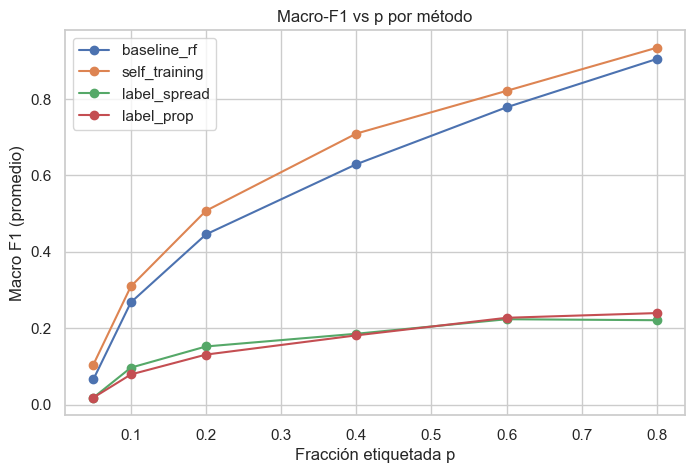

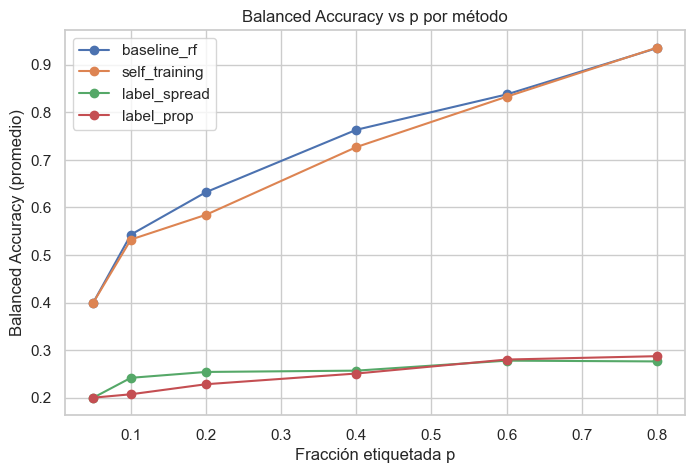

In [121]:
import matplotlib.pyplot as plt

methods_to_plot = ["baseline_rf", "self_training", "label_spread","label_prop"]  

plt.figure(figsize=(8,5))
for m in methods_to_plot:
    sub = summary[summary["method"] == m]
    plt.plot(sub["p"], sub["macro_f1_mean"], marker="o", label=m)

plt.xlabel("Fracción etiquetada p")
plt.ylabel("Macro F1 (promedio)")
plt.title("Macro-F1 vs p por método")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
for m in methods_to_plot:
    sub = summary[summary["method"] == m]
    plt.plot(sub["p"], sub["bal_acc_mean"], marker="o", label=m)

plt.xlabel("Fracción etiquetada p")
plt.ylabel("Balanced Accuracy (promedio)")
plt.title("Balanced Accuracy vs p por método")
plt.legend()
plt.grid(True)
plt.show()


In [122]:
from scipy.stats import wilcoxon

tests = []

# Obtener baseline por p y rep
baseline = results_df[results_df["method"] == "baseline_rf"]

# Métodos semisupervisados
semi_methods = ["self_training", "label_prop", "label_spread"]

for method in semi_methods:
    semi = results_df[results_df["method"] == method]

    for p in ps:
        base_p = baseline[baseline["p"] == p].sort_values("rep")
        semi_p = semi[semi["p"] == p].sort_values("rep")

        # Alinear por repeticiones
        merged = base_p.merge(
            semi_p,
            on="rep",
            suffixes=("_base", "_semi")
        )

        if len(merged) < 3:
            continue  # Evitar muestras demasiado pequeñas

        # Comparar macro_f1
        stat_f1, pval_f1 = wilcoxon(
            merged["macro_f1_semi"], 
            merged["macro_f1_base"]
        )

        # Comparar balanced accuracy
        stat_bal, pval_bal = wilcoxon(
            merged["balanced_acc_semi"], 
            merged["balanced_acc_base"]
        )

        tests.append({
            "method": method,
            "p": p,
            "wilcoxon_macro_f1_stat": stat_f1,
            "wilcoxon_macro_f1_pval": pval_f1,
            "wilcoxon_balacc_stat": stat_bal,
            "wilcoxon_balacc_pval": pval_bal,
        })

tests_df = pd.DataFrame(tests).sort_values(["method", "p"])
tests_df


c:\Users\marie\OneDrive\Documentos\UNIVERSIDAD\Séptimo Semestre\Aprendizaje Automático\PROYECTOFINAL\ml-cooperativas-segmento1\.venv\Lib\site-packages\scipy\stats\_wilcoxon.py:178: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


,method,p,wilcoxon_macro_f1_stat,wilcoxon_macro_f1_pval,wilcoxon_balacc_stat,wilcoxon_balacc_pval
6,label_prop,0.05,0.0,6.442373e-10,0.0,1.537460e-12
7,label_prop,0.10,0.0,7.384431e-10,0.0,7.166451e-10
8,label_prop,0.20,0.0,7.438163e-10,0.0,7.377739e-10
9,label_prop,0.40,0.0,7.529634e-10,0.0,7.502427e-10
10,label_prop,0.60,0.0,7.551805e-10,0.0,7.543271e-10
11,label_prop,0.80,0.0,1.776357e-15,0.0,7.526228e-10
12,label_spread,0.05,0.0,6.442373e-10,0.0,1.537460e-12
13,label_spread,0.10,0.0,7.521122e-10,0.0,7.473616e-10
14,label_spread,0.20,0.0,7.504125e-10,0.0,7.449964e-10
15,label_spread,0.40,0.0,7.529634e-10,0.0,7.493943e-10


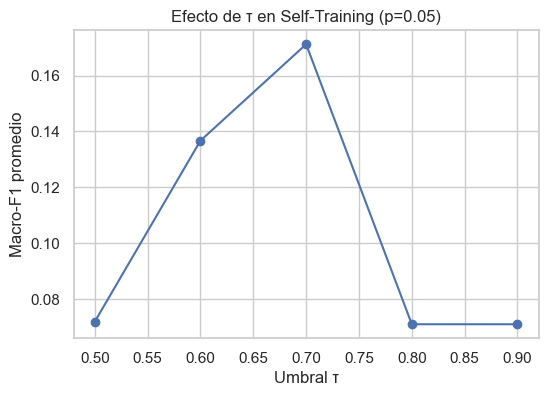

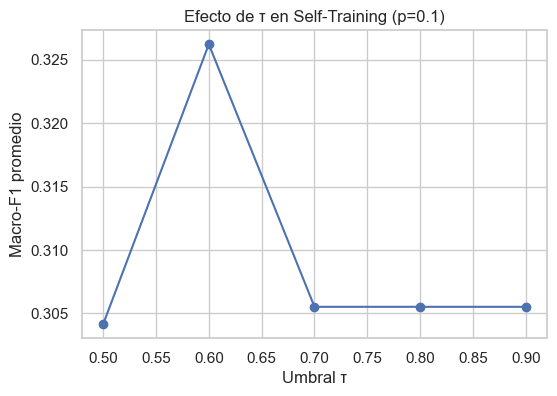

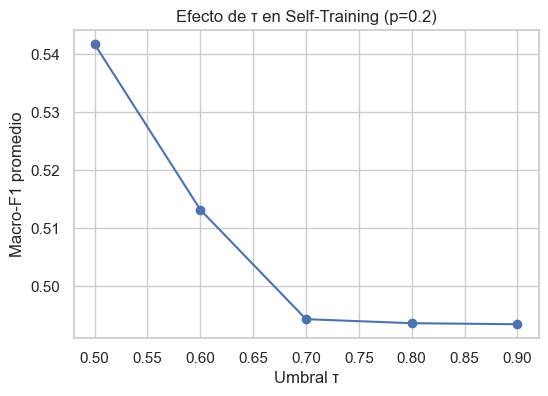

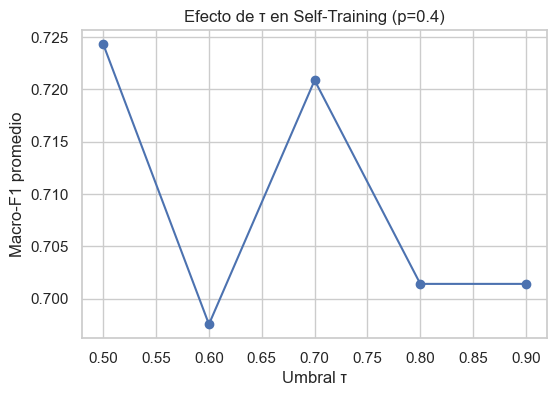

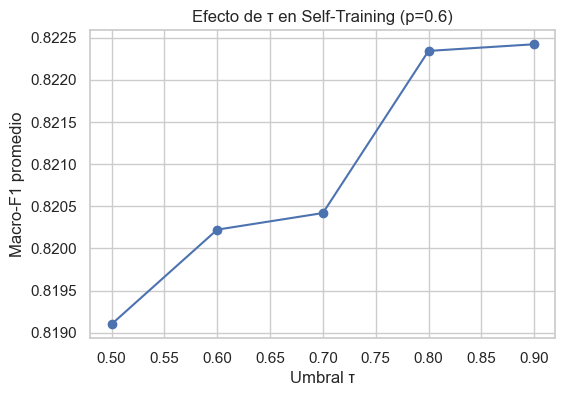

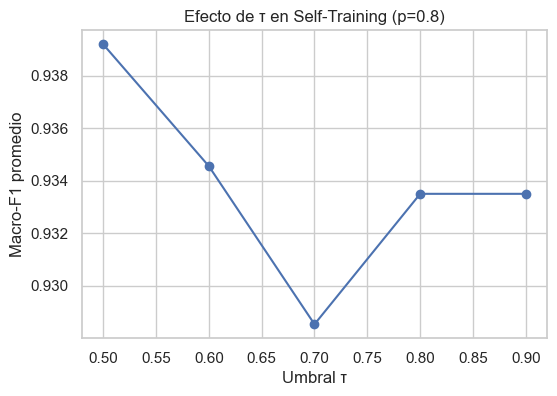

In [123]:
# ================================
# EFECTO DEL UMBRAL τ EN SELF-TRAINING
# ================================

import matplotlib.pyplot as plt

# Agrupar métricas promedio por p y tau
tau_summary = (
    results_df[results_df["method"] == "self_training"]
    .groupby(["p", "tau"], as_index=False)
    .agg(macro_f1_mean=("macro_f1", "mean"))
)

# Graficar para cada p
for p_target in ps:
    sub = tau_summary[tau_summary["p"] == p_target]

    if sub.empty:
        continue

    plt.figure(figsize=(6,4))
    plt.plot(sub["tau"], sub["macro_f1_mean"], marker="o")
    plt.xlabel("Umbral τ")
    plt.ylabel("Macro-F1 promedio")
    plt.title(f"Efecto de τ en Self-Training (p={p_target})")
    plt.grid(True)
    plt.show()


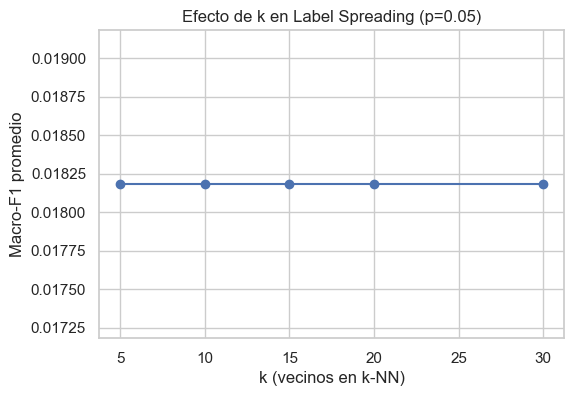

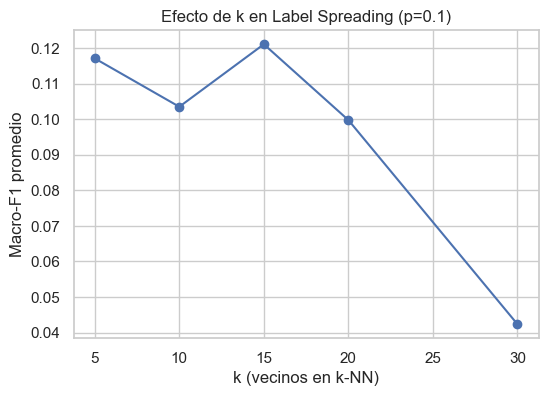

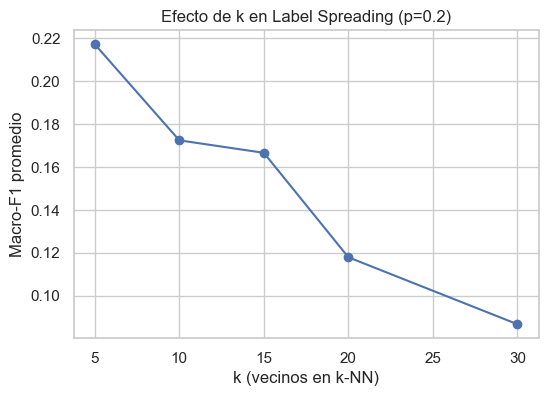

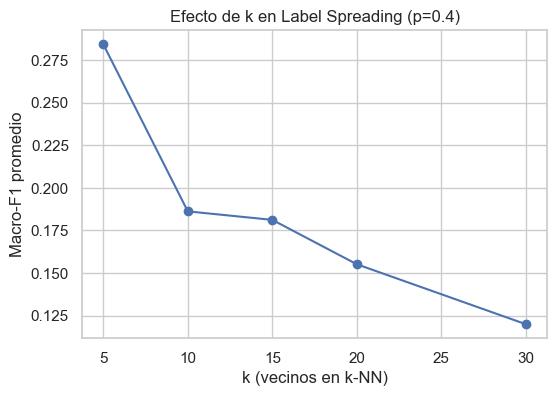

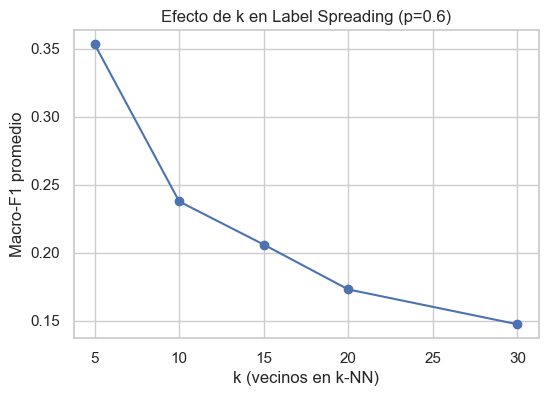

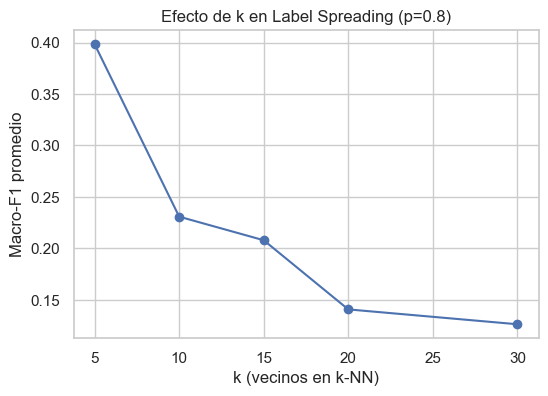

In [124]:
# ================================
# EFECTO DE k EN LABEL SPREADING
# ================================

# Agrupar métricas promedio por p y k
k_summary_ls = (
    results_df[results_df["method"] == "label_spread"]
    .groupby(["p", "k"], as_index=False)
    .agg(macro_f1_mean=("macro_f1", "mean"))
)

# Graficar para cada p
for p_target in ps:
    sub = k_summary_ls[k_summary_ls["p"] == p_target]

    if sub.empty:
        continue

    plt.figure(figsize=(6,4))
    plt.plot(sub["k"], sub["macro_f1_mean"], marker="o")
    plt.xlabel("k (vecinos en k-NN)")
    plt.ylabel("Macro-F1 promedio")
    plt.title(f"Efecto de k en Label Spreading (p={p_target})")
    plt.grid(True)
    plt.show()


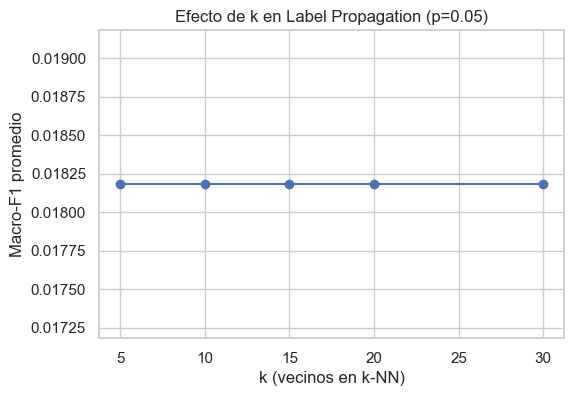

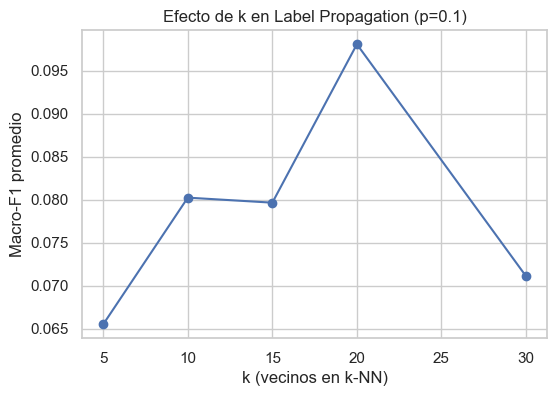

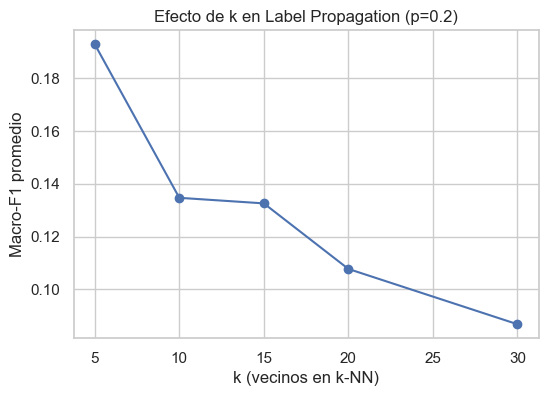

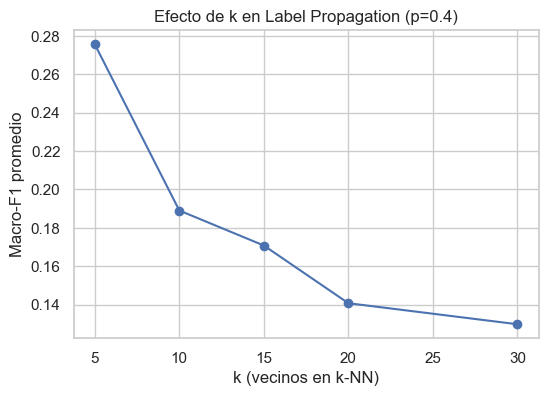

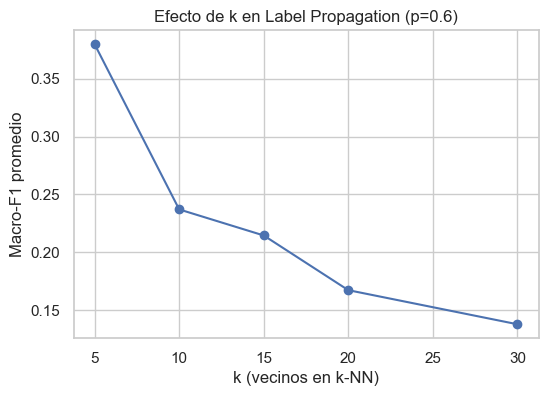

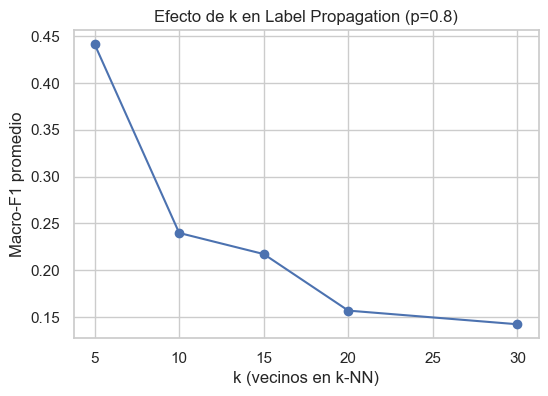

In [125]:
# ================================
# EFECTO DE k EN LABEL PROPAGATION
# ================================

# Agrupar métricas promedio por p y k
k_summary_lp = (
    results_df[results_df["method"] == "label_prop"]
    .groupby(["p", "k"], as_index=False)
    .agg(macro_f1_mean=("macro_f1", "mean"))
)

# Graficar para cada p
for p_target in ps:
    sub = k_summary_lp[k_summary_lp["p"] == p_target]

    if sub.empty:
        continue

    plt.figure(figsize=(6,4))
    plt.plot(sub["k"], sub["macro_f1_mean"], marker="o")
    plt.xlabel("k (vecinos en k-NN)")
    plt.ylabel("Macro-F1 promedio")
    plt.title(f"Efecto de k en Label Propagation (p={p_target})")
    plt.grid(True)
    plt.show()


                                              feature  importance
12  GASTOS DE OPERACION ESTIMADOS / TOTAL ACTIVO P...    0.094639
13           GASTOS DE OPERACION  / MARGEN FINANCIERO    0.072822
3       MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO    0.054177
0   ( PATRIMONIO + RESULTADOS ) / ACTIVOS INMOVILI...    0.049399
26                           CARTERA POR VENCER TOTAL    0.048798
17  MARGEN DE INTERMEDIACIÓN ESTIMADO / ACTIVO PRO...    0.048742
2             ACTIVOS PRODUCTIVOS / PASIVOS CON COSTO    0.042806
1                 ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS    0.041740
9     COBERTURA DE LA CARTERA DE CREDITO INMOBILIARIO    0.040913
31             INDICE DE CAPITALIZACION NETO: FK / FI    0.039437
30  FI = 1 + (ACTIVOS IMPRODUCTIVOS / ACTIVOS TOTA...    0.037882
10            COBERTURA DE LA CARTERA DE MICROCREDITO    0.033455
11               COBERTURA DE LA CARTERA PROBLEMÁTICA    0.032289
29            CARTERA IMPRODUCTIVA / PATRIMONIO (DIC)    0.029288
8         

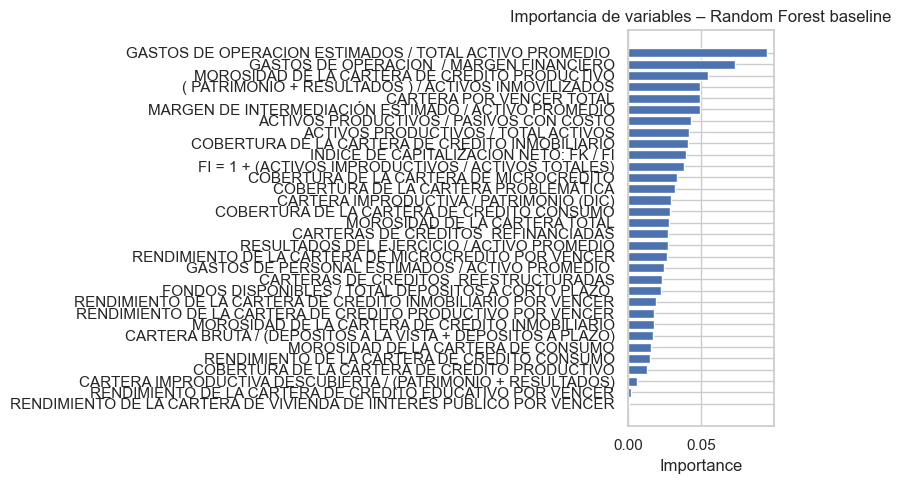

In [127]:
# ============================================
# IMPORTANCIA DE VARIABLES DEL BASELINE RF
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Elegir una corrida específica del baseline (ejemplo: p = 0.80 y rep = 0)
p_target = 0.80
rep_target = 0

sub = results_df[
    (results_df["method"] == "baseline_rf") &
    (results_df["p"] == p_target) &
    (results_df["rep"] == rep_target)
]

if sub.empty:
    print("No se encontró baseline para ese p/rep.")
else:
    # Necesitamos reconstruir el RF entrenado
    # Para esto debemos volver a entrenar el RF con los datos correspondientes
    # (misma semilla para reproducibilidad)

    rs = base_seed + rep_target
    n_labeled = int(round(p_target * N))

    # --- Repetir el proceso para obtener idx_L de ese rep ---
    # === EXACTAMENTE como en tu loop principal ===
    # (Versión simplificada: puedes copiar tu propio split aquí)
    
    # Para simplificar, usamos todos los datos etiquetados en este punto:
    rf = RandomForestClassifier(
        n_estimators=300,
        random_state=rs,
        class_weight="balanced"
    )
    rf.fit(X_scaled, y)  # Entrenamos con todo (solo para obtener importancia de features)

    importances = rf.feature_importances_

    # Crear tabla ordenada
    feat_names = df_clean.columns
    imp_df = pd.DataFrame({
        "feature": feat_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print(imp_df)

    # --- Gráfico ---
    plt.figure(figsize=(8,5))
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.gca().invert_yaxis()
    plt.title("Importancia de variables – Random Forest baseline")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


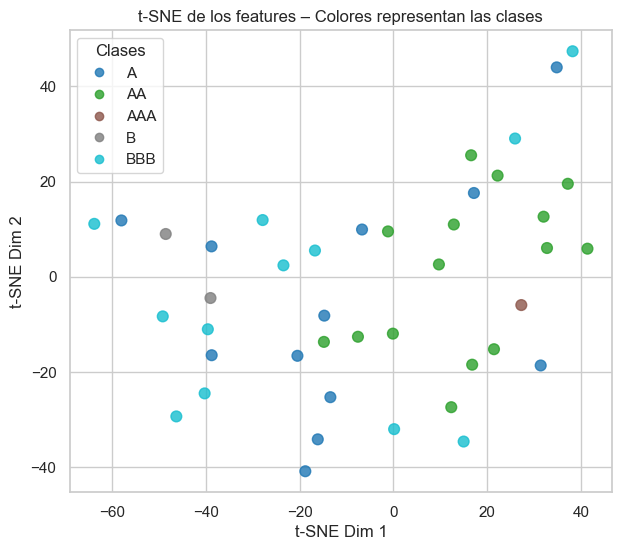

In [128]:
# ============================================
# TSNE – VISUALIZACIÓN DE LOS FEATURES
# ============================================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reducir a 2D con TSNE
tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=5,          # recomendable con dataset pequeño
    random_state=123
)

X_tsne = tsne.fit_transform(X_scaled)

# --- Graficar ---
plt.figure(figsize=(7,6))

scatter = plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=y,
    cmap="tab10",
    s=60,
    alpha=0.8
)

plt.title("t-SNE de los features – Colores representan las clases")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)

# Leyenda con nombres reales
handles, _ = scatter.legend_elements()
plt.legend(handles, le.inverse_transform(classes), title="Clases")

plt.show()
